In [1]:
import GCRCatalogs
import matplotlib.pyplot as plt
import corner
import numpy as np
from astropy.table import Table
import pandas as pd
import os
import h5py

## Read skysim v3.1.0 and cosmoDC2 v1.1.4 catalogs with the GCRCatalogs class

In [2]:
skysim3 = GCRCatalogs.load_catalog('skysim_v3.1.0')
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [3]:
skysim3_allcols = skysim3.list_all_native_quantities()
cosmodc2_allcols = cosmodc2.list_all_native_quantities()

In [4]:
skysim3_relevantcols = ['LSST_obs_g','LSST_obs_i','LSST_obs_r','LSST_obs_u','LSST_obs_y','LSST_obs_z','LSST_rest_G','LSST_rest_I','LSST_rest_R',
                        'LSST_rest_U' ,'LSST_rest_Y','LSST_rest_Z','lg_met_mean','lg_met_scatter','log_sm','log_ssfr','obs_sfr','obs_sm',
                        'redshift','sfr','HSC_obs_g','HSC_obs_i','HSC_obs_r','HSC_obs_y','HSC_obs_z','HSC_rest_G','HSC_rest_I','HSC_rest_R',
                        'HSC_rest_Y','HSC_rest_Z']

In [5]:
cosmodc2_relevantcols = ['LSST_filters/magnitude:LSST_u:rest','LSST_filters/magnitude:LSST_g:rest','LSST_filters/magnitude:LSST_r:rest',
                         'LSST_filters/magnitude:LSST_i:rest','LSST_filters/magnitude:LSST_z:rest','LSST_filters/magnitude:LSST_y:rest',
                         'LSST_filters/magnitude:LSST_u:observed','LSST_filters/magnitude:LSST_g:observed','LSST_filters/magnitude:LSST_r:observed',
                         'LSST_filters/magnitude:LSST_i:observed','LSST_filters/magnitude:LSST_z:observed','LSST_filters/magnitude:LSST_y:observed',
                         'baseDC2/sfr','baseDC2/redshift','baseDC2/obs_sfr','baseDC2/obs_sm','baseDC2/sm']

In [6]:
skysim3_quantities = skysim3.get_quantities(skysim3_relevantcols, native_filters=['healpix_pixel == 9816'])
cosmodc2_quantities = cosmodc2.get_quantities(cosmodc2_relevantcols, native_filters=['healpix_pixel == 9816'])

In [7]:
skysim3_df = pd.DataFrame(skysim3_quantities)
cosmodc2_df = pd.DataFrame(cosmodc2_quantities)

## Select a random subset of 100k objects per catalog to facilitate plotting

In [8]:
skysim3_df_100k = skysim3_df.sample(n=100000)
cosmodc2_df_100k = cosmodc2_df.sample(n=100000)

## Compare physical and photometric properties distribution between skysim v3.1.0 and cosmoDC2 v1.1.4

#### Redshift distribution comparison

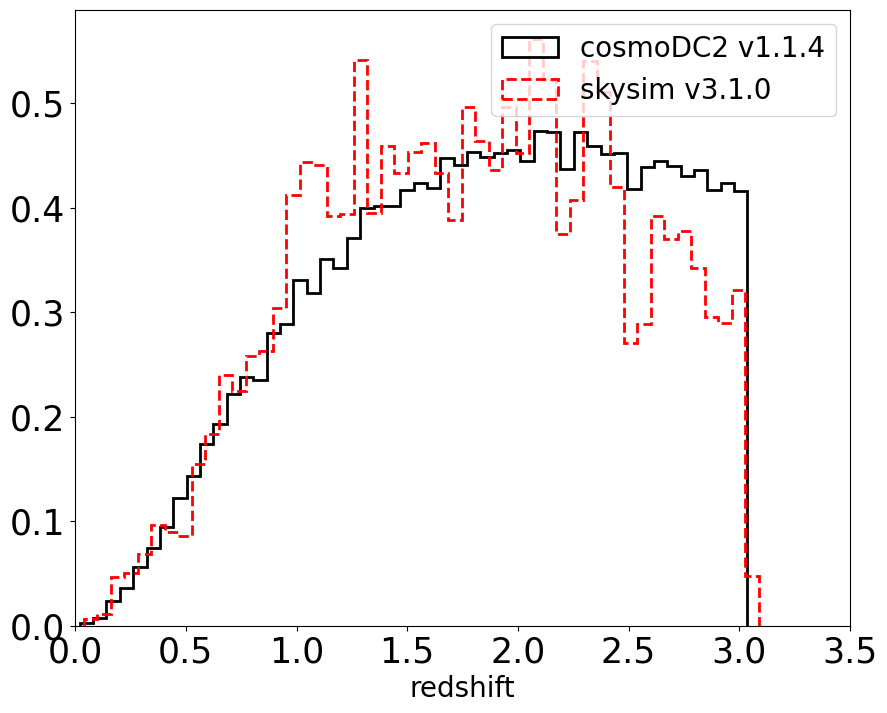

In [10]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.hist(cosmodc2_df_100k['baseDC2/redshift'], bins=50, lw=2, ls='solid', color='black', histtype='step',density=True, label='cosmoDC2 v1.1.4')
plt.hist(skysim3_df_100k['redshift'], bins=50, lw=2, ls='dashed', color='red', histtype='step',density=True, label='skysim v3.1.0')
plt.legend(loc='upper right', fontsize=20)
plt.xlim(0,3.5)
plt.xlabel(r'redshift', fontsize=20)
plt.ylabel(r'', fontsize=20)
plt.show()

#### Stellar mass - Star formation rate plane comparison

<Figure size 1000x800 with 0 Axes>

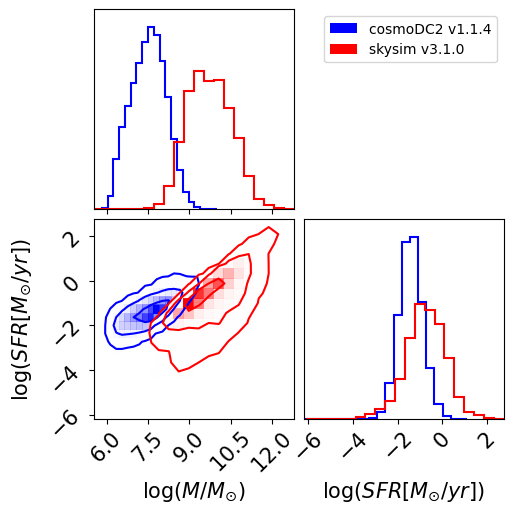

In [11]:
w = np.where((cosmodc2_df_100k['baseDC2/sm'].values>0)&(cosmodc2_df_100k['baseDC2/sfr'].values>0))
prop_cosmodc2 = np.empty((len(cosmodc2_df_100k['baseDC2/sm'].values[w]), 2))
prop_cosmodc2[:, 0] = np.log10(cosmodc2_df_100k['baseDC2/sm'].values[w])
prop_cosmodc2[:, 1] = np.log10(cosmodc2_df_100k['baseDC2/sfr'].values[w])

prop_skysim = np.empty((len(skysim3_df_100k['log_sm']),2))
prop_skysim[:, 0] = skysim3_df_100k['log_sm'].values
prop_skysim[:, 1] = np.log10(skysim3_df_100k['sfr'].values)

plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(prop_cosmodc2, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$\log(M/M_{\odot})$',r'$\log(SFR[M_{\odot}/yr])$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(prop_skysim, fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$\log(M/M_{\odot})$',r'$\log(SFR[M_{\odot}/yr])$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

#### Observed stellar mass - observed star formation rate comparison

<Figure size 1000x800 with 0 Axes>

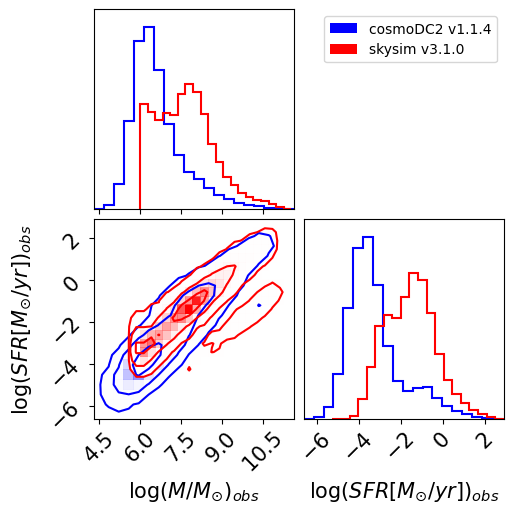

In [12]:
w = np.where((cosmodc2_df_100k['baseDC2/obs_sm'].values>0)&(cosmodc2_df_100k['baseDC2/obs_sfr'].values>0))
prop_cosmodc2 = np.empty((len(cosmodc2_df_100k['baseDC2/obs_sm'].values[w]), 2))
prop_cosmodc2[:, 0] = np.log10(cosmodc2_df_100k['baseDC2/obs_sm'].values[w])
prop_cosmodc2[:, 1] = np.log10(cosmodc2_df_100k['baseDC2/obs_sfr'].values[w])

prop_skysim = np.empty((len(skysim3_df_100k['obs_sm']),2))
prop_skysim[:, 0] = np.log10(skysim3_df_100k['obs_sm'].values)
prop_skysim[:, 1] = np.log10(skysim3_df_100k['obs_sfr'].values)

plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(prop_cosmodc2, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(prop_skysim, fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

#### LSST rest-frame magnitudes and colours comparison

In [13]:
wavebands = ['u', 'g', 'r', 'i', 'z', 'y']
lsst_restframe_mags_cosmodc2 = np.array([cosmodc2_df_100k['LSST_filters/magnitude:LSST_{}:rest'.format(waveband)].values for waveband in wavebands])
lsst_restframe_mags_skysim = np.array([skysim3_df_100k['LSST_rest_{}'.format(waveband.capitalize())].values for waveband in wavebands])

<Figure size 1000x800 with 0 Axes>

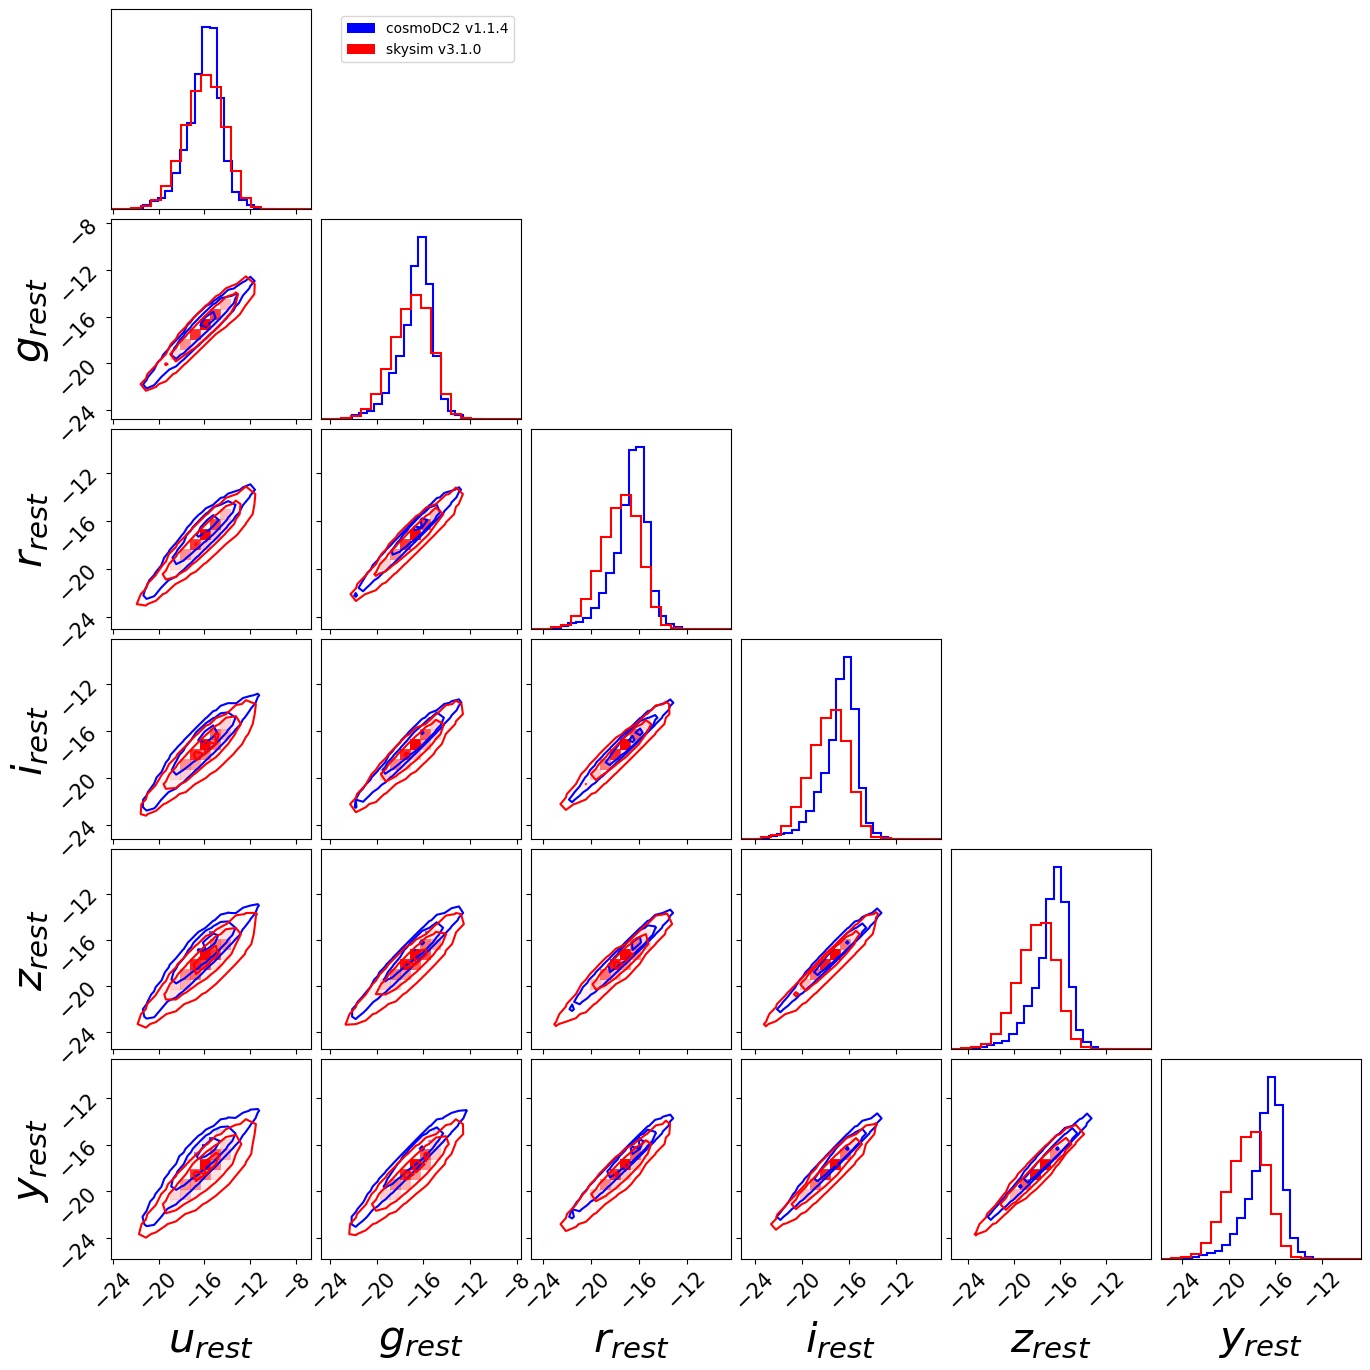

In [14]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(np.swapaxes(lsst_restframe_mags_cosmodc2,0,1), hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$u_{rest}$',r'$g_{rest}$',r'$r_{rest}$',r'$i_{rest}$',r'$z_{rest}$',r'$y_{rest}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(np.swapaxes(lsst_restframe_mags_skysim,0,1), fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$u_{rest}$',r'$g_{rest}$',r'$r_{rest}$',r'$i_{rest}$',r'$z_{rest}$',r'$y_{rest}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

In [15]:
lsst_restframe_colours_cosmodc2 = np.array([cosmodc2_df_100k['LSST_filters/magnitude:LSST_{}:rest'.format(wavebands[i])].values - cosmodc2_df_100k['LSST_filters/magnitude:LSST_{}:rest'.format(wavebands[i+1])].values for i in range(len(wavebands)-1)])
lsst_restframe_colours_skysim = np.array([skysim3_df_100k['LSST_rest_{}'.format(wavebands[i].capitalize())].values-skysim3_df_100k['LSST_rest_{}'.format(wavebands[i+1].capitalize())].values for i in range(len(wavebands)-1)])

<Figure size 1000x800 with 0 Axes>

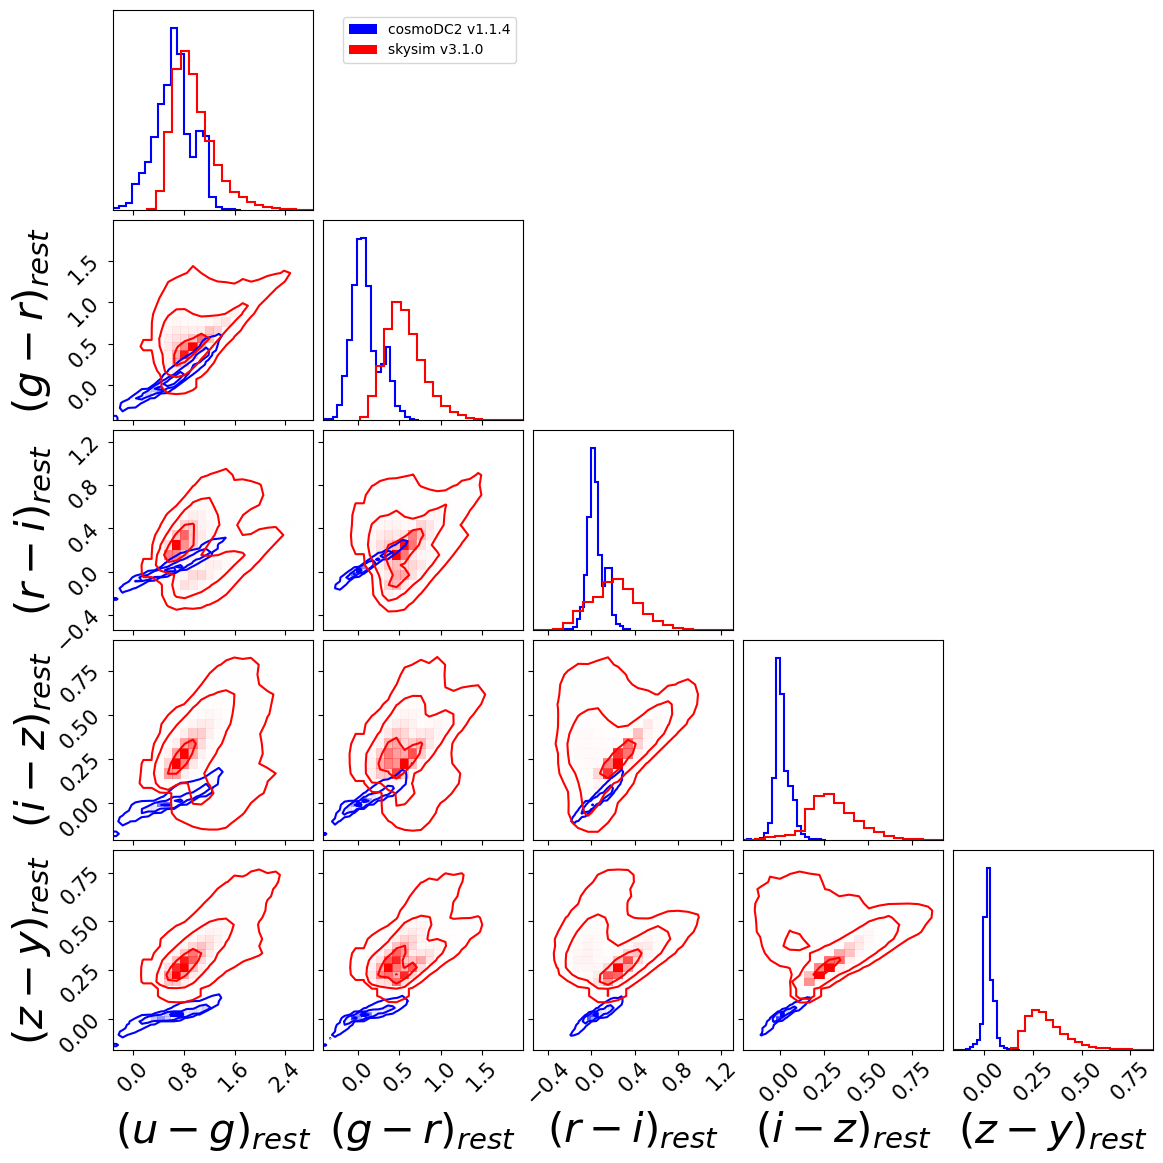

In [16]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(np.swapaxes(lsst_restframe_colours_cosmodc2,0,1), hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$(u-g)_{rest}$',r'$(g-r)_{rest}$',r'$(r-i)_{rest}$',r'$(i-z)_{rest}$',r'$(z-y)_{rest}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(np.swapaxes(lsst_restframe_colours_skysim,0,1), fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$(u-g)_{rest}$',r'$(g-r)_{rest}$',r'$(r-i)_{rest}$',r'$(i-z)_{rest}$',r'$(z-y)_{rest}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

#### LSST observed-frame magnitudes and colours comparison

In [17]:
wavebands = ['u', 'g', 'r', 'i', 'z', 'y']
lsst_obsframe_mags_cosmodc2 = np.array([cosmodc2_df_100k['LSST_filters/magnitude:LSST_{}:observed'.format(waveband)].values for waveband in wavebands])
lsst_obsframe_mags_skysim = np.array([skysim3_df_100k['LSST_obs_{}'.format(waveband)].values for waveband in wavebands])

<Figure size 1000x800 with 0 Axes>

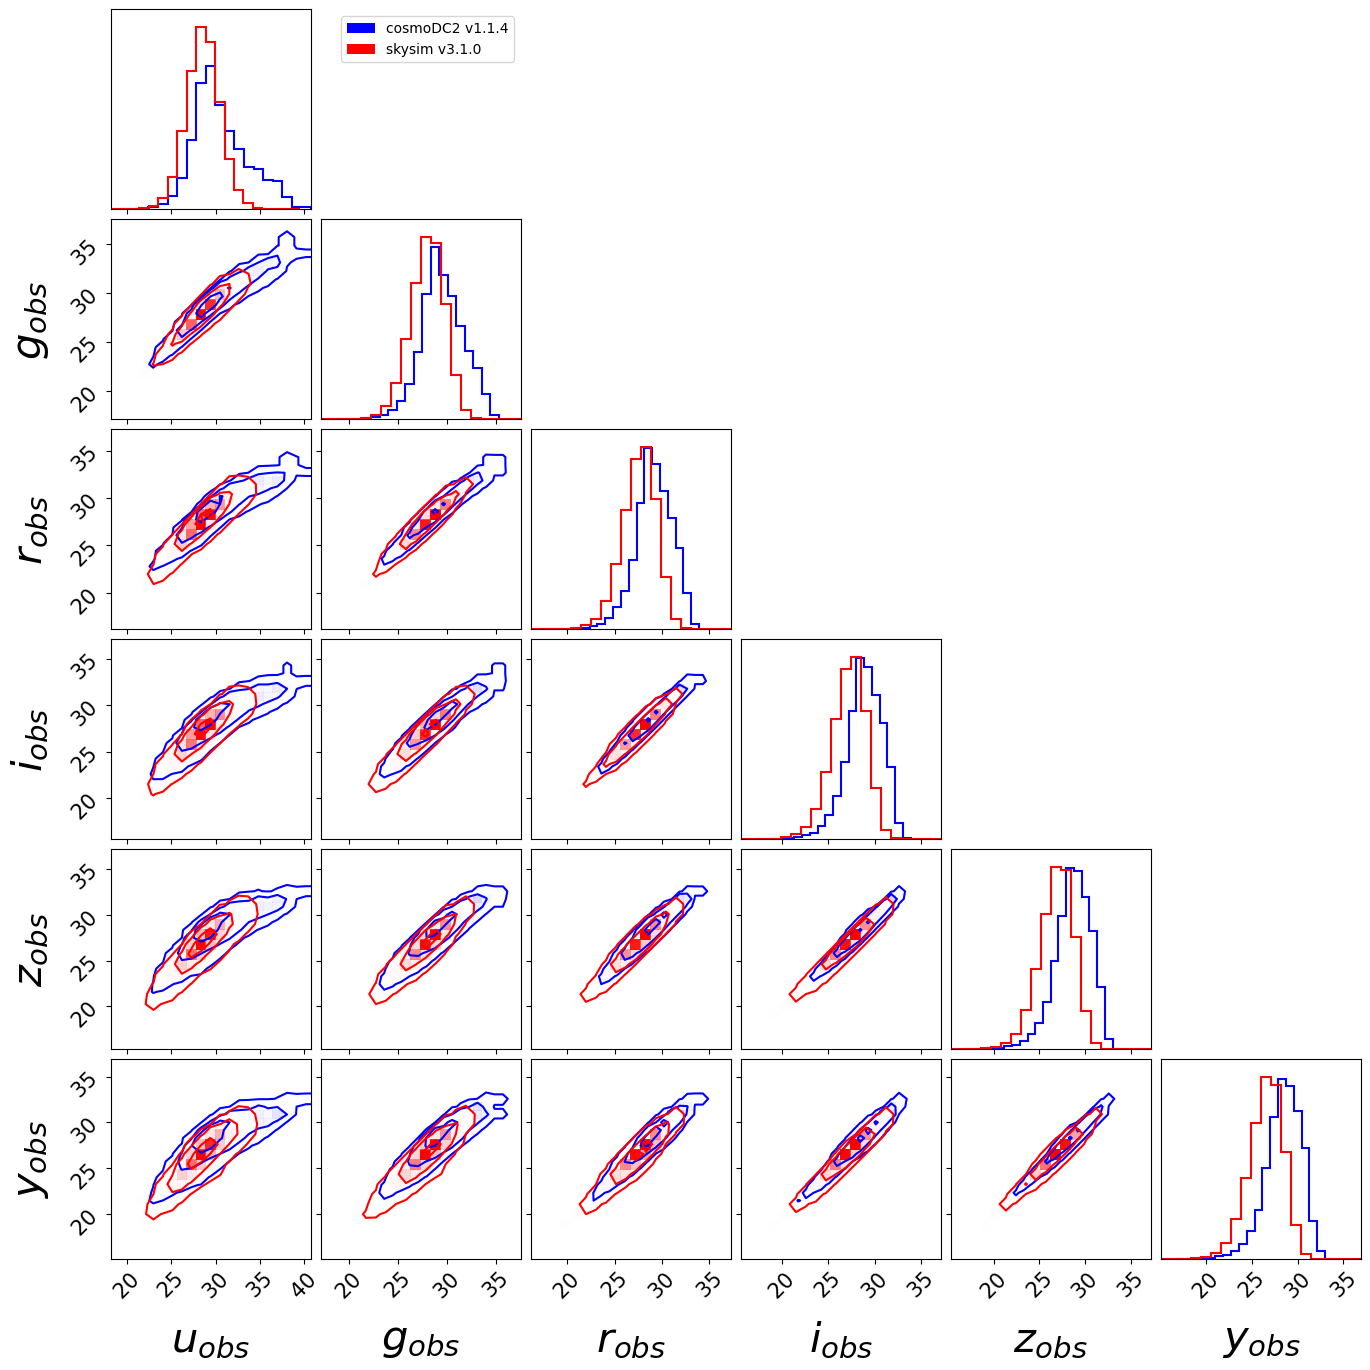

In [18]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(np.swapaxes(lsst_obsframe_mags_cosmodc2,0,1), hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$u_{obs}$',r'$g_{obs}$',r'$r_{obs}$',r'$i_{obs}$',r'$z_{obs}$',r'$y_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(np.swapaxes(lsst_obsframe_mags_skysim,0,1), fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$u_{obs}$',r'$g_{obs}$',r'$r_{obs}$',r'$i_{obs}$',r'$z_{obs}$',r'$y_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

In [19]:
lsst_obsframe_colours_cosmodc2 = np.array([cosmodc2_df_100k['LSST_filters/magnitude:LSST_{}:observed'.format(wavebands[i])].values - cosmodc2_df_100k['LSST_filters/magnitude:LSST_{}:observed'.format(wavebands[i+1])].values for i in range(len(wavebands)-1)])
lsst_obsframe_colours_skysim = np.array([skysim3_df_100k['LSST_obs_{}'.format(wavebands[i])].values-skysim3_df_100k['LSST_obs_{}'.format(wavebands[i+1])].values for i in range(len(wavebands)-1)])

<Figure size 1000x800 with 0 Axes>

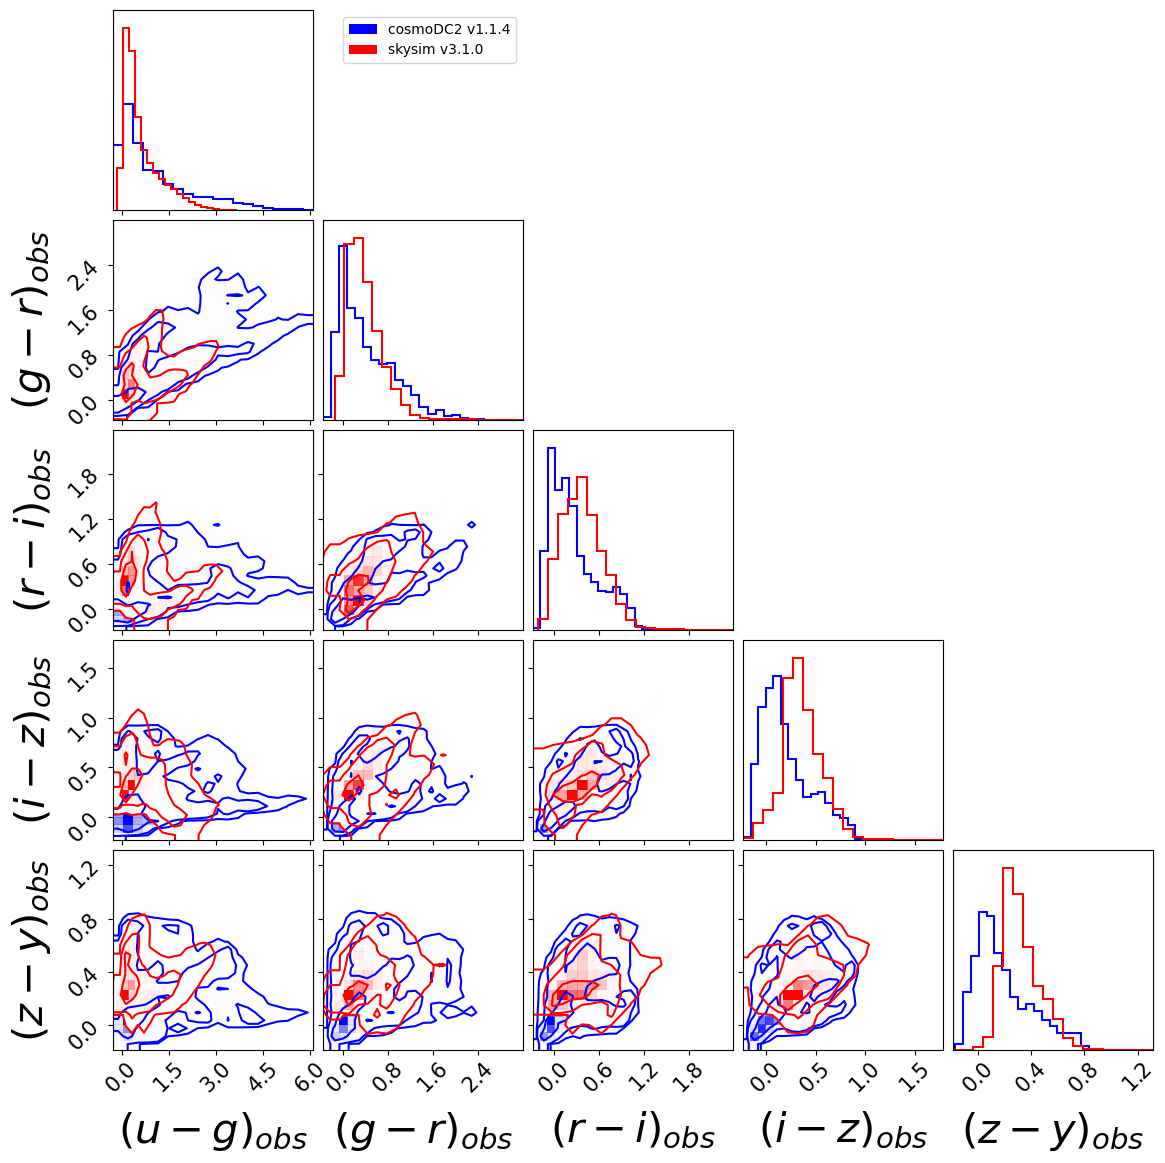

In [20]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(np.swapaxes(lsst_obsframe_colours_cosmodc2,0,1), hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$(u-g)_{obs}$',r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(np.swapaxes(lsst_obsframe_colours_skysim,0,1), fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$(u-g)_{obs}$',r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

#### Observed color-redshift relation comparison

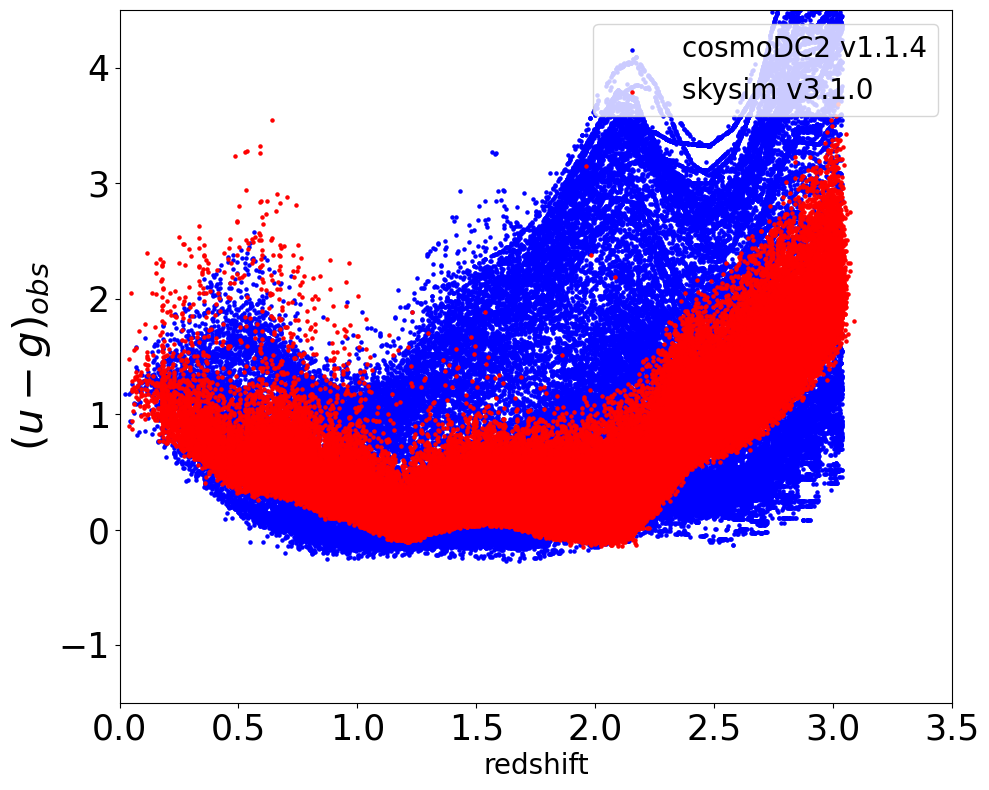

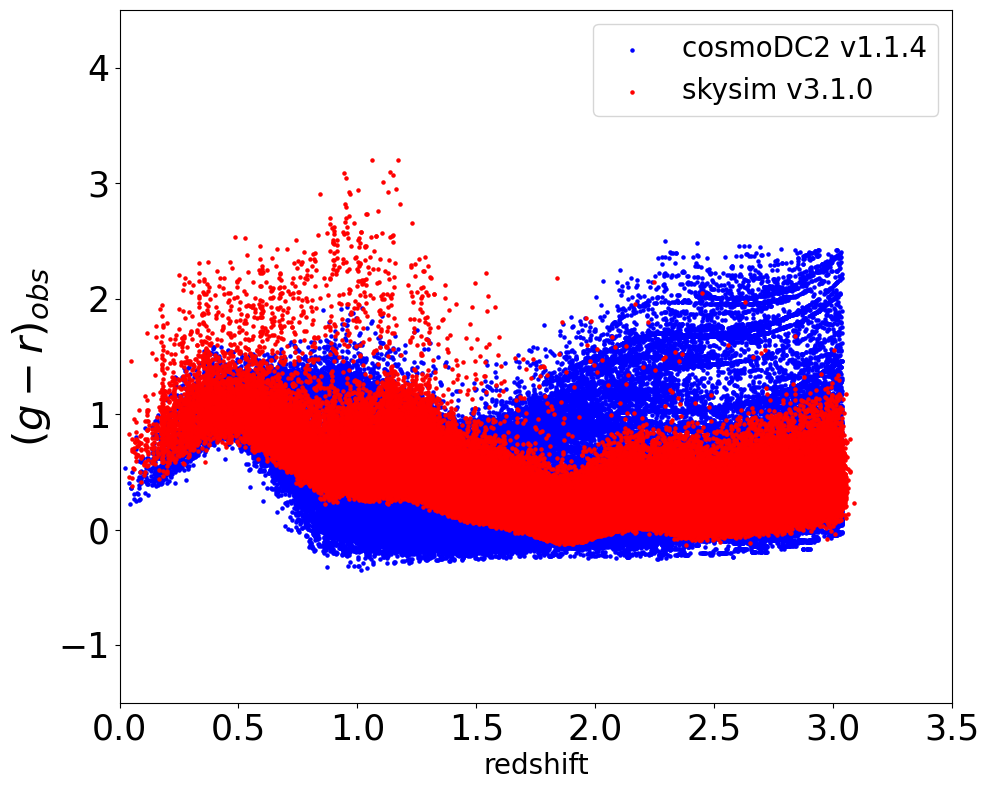

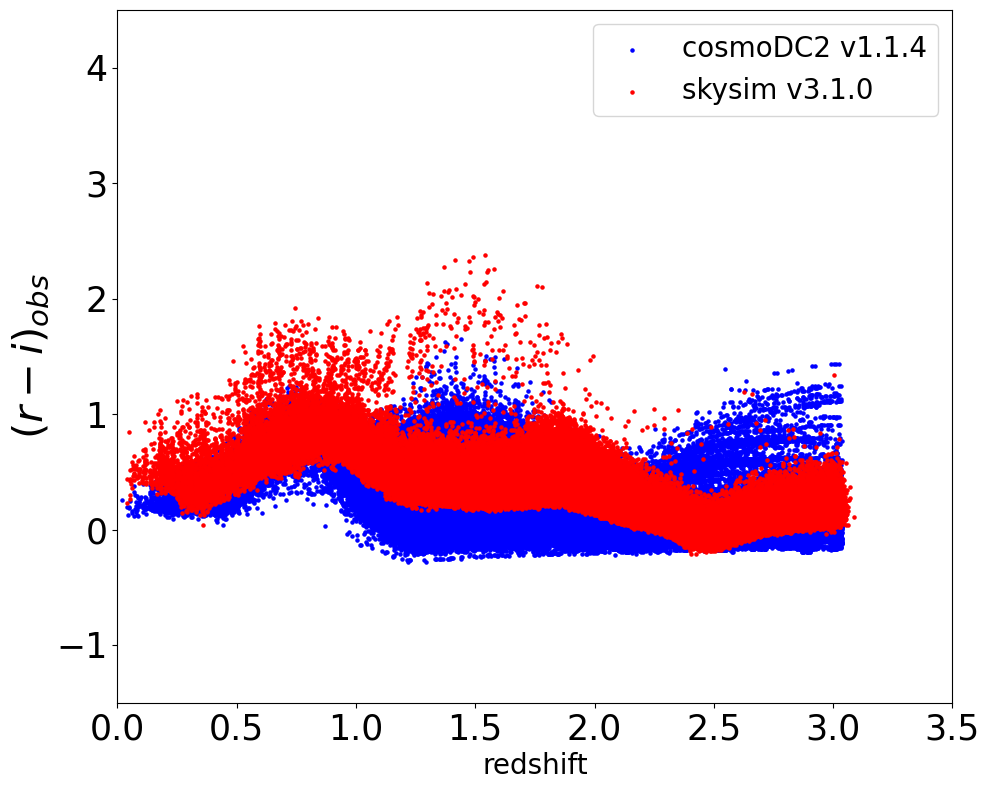

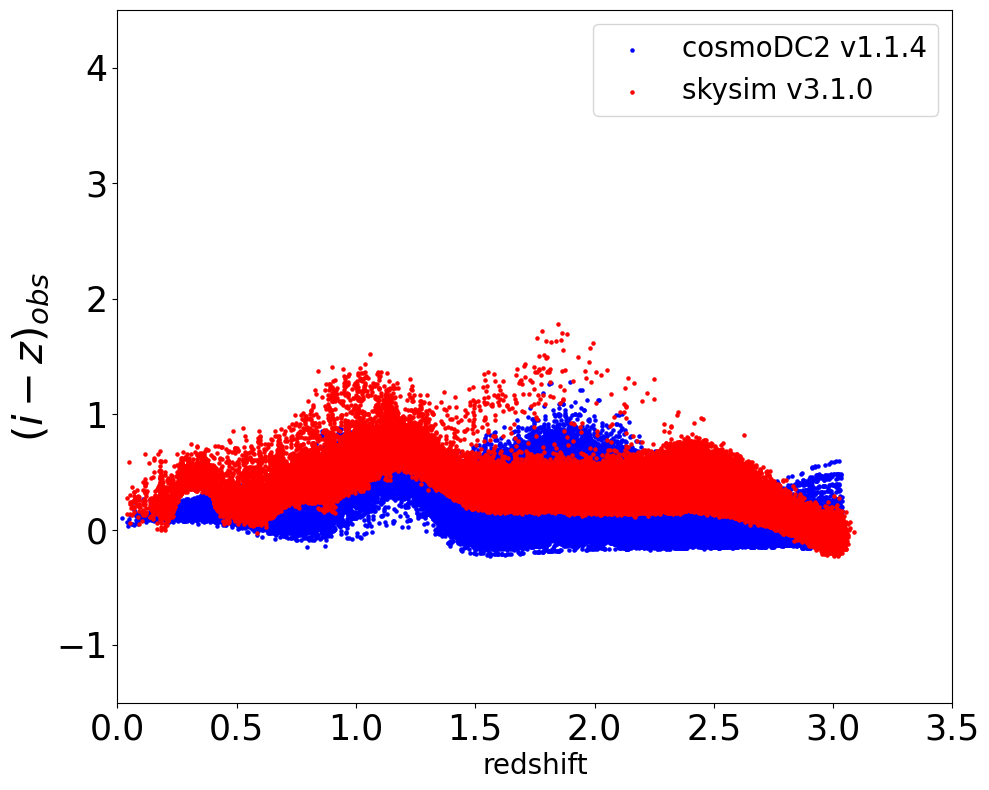

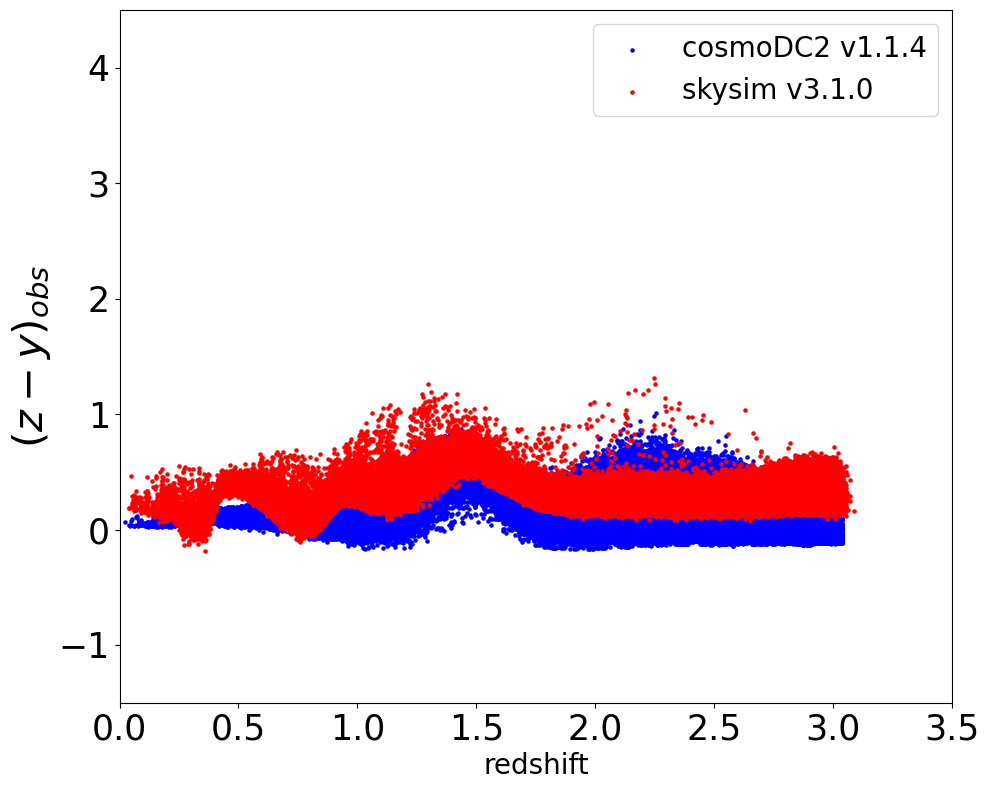

In [23]:
colours = [r'$(u-g)_{obs}$',r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$']
for i in range(len(colours)):
    plt.clf()
    plt.rcParams['figure.figsize']=(10,8)
    plt.rcParams['xtick.labelsize']=25
    plt.rcParams['ytick.labelsize']=25
    plt.scatter(cosmodc2_df_100k['baseDC2/redshift'], lsst_obsframe_colours_cosmodc2[i,:], s=5, color='blue', label='cosmoDC2 v1.1.4')
    plt.scatter(skysim3_df_100k['redshift'], lsst_obsframe_colours_skysim[i,:], s=5, color='red', label='skysim v3.1.0')
    plt.legend(loc='upper right', fontsize=20)
    plt.xlim(0,3.5)
    plt.ylim(-1.5,4.5)
    plt.ylabel(colours[i], fontsize=30)
    plt.xlabel(r'redshift', fontsize=20)
    plt.tight_layout()
    plt.show()

## Load COSMOS2020 catalog

In [24]:
cosmos2020 = Table.read('COSMOS2020_CLASSIC_R1_v2.0.fits', format='fits')

In [25]:
mask_bad_values = np.where((cosmos2020['CFHT_u_MAG_AUTO'] > 0) & 
                             (cosmos2020['HSC_i_MAG_AUTO'] > 0)&
                             (cosmos2020['HSC_g_MAG_AUTO'] > 0)&
                             (cosmos2020['HSC_r_MAG_AUTO'] > 0) & 
                             (cosmos2020['HSC_z_MAG_AUTO'] > 0)&
                             (cosmos2020['HSC_y_MAG_AUTO'] > 0)&
                             (cosmos2020['UVISTA_J_MAG_AUTO'] > 0) &
                             (cosmos2020['UVISTA_H_MAG_AUTO'] > 0) & 
                             (cosmos2020['UVISTA_Ks_MAG_AUTO'] > 0))

In [26]:
cosmos2020 = cosmos2020[mask_bad_values]

## Since skysim and cosmoDC2 catalogs contain model galaxies with noiseless properties, we compare them against COSMOS2020 observed galaxies by applying the LSST Y1 Lens galaxies cut of 24.1 in the i-band. We use the HSC i-band since the LSST i-band is absent in COSMOS.

In [27]:
skysim3_df_lsst_y1 = skysim3_df.loc[skysim3_df['LSST_obs_i']<=24.1]
cosmodc2_df_lsst_y1 = cosmodc2_df.loc[cosmodc2_df['LSST_filters/magnitude:LSST_i:observed']<=24.1]

In [28]:
mask_cosmos_lsst_y1 = np.where(cosmos2020['HSC_i_MAG_AUTO']<=24.1)
cosmos2020_lsst_y1 = cosmos2020[mask_cosmos_lsst_y1]

In [29]:
print(len(skysim3_df_lsst_y1),len(cosmodc2_df_lsst_y1),len(cosmos2020_lsst_y1))

279196 288512 164702


## Compare physical properties distribution among skysim v3.1.0, cosmoDC2 v1.1.4 and COSMOS2020, and photometric properties distribution between Skysim and COSMOS2020

#### Redshift distribution comparison between cosmoDC2 v1.1.4 and skysim v3.1.0 input model redshifts and COSMOS2020 observed redshifts obtained via Eazy photo-z (maximum a-posteriori).

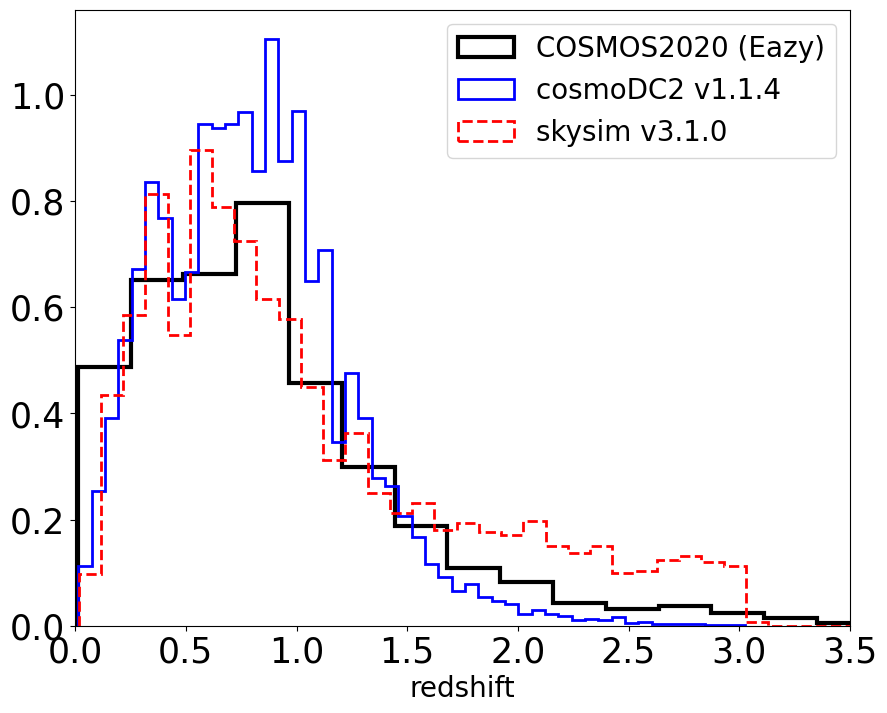

In [32]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.hist(cosmos2020_lsst_y1['ez_z_phot'], bins=50, lw=3, ls='solid', color='black', histtype='step',density=True, label='COSMOS2020 (Eazy)')
plt.hist(cosmodc2_df_lsst_y1['baseDC2/redshift'], bins=50, lw=2, ls='solid', color='blue', histtype='step',density=True, label='cosmoDC2 v1.1.4')
plt.hist(skysim3_df_lsst_y1['redshift'], bins=50, lw=2, ls='dashed', color='red', histtype='step',density=True, label='skysim v3.1.0')
plt.legend(loc='upper right', fontsize=20)
plt.xlim(0,3.5)
plt.xlabel(r'redshift', fontsize=20)
plt.ylabel(r'', fontsize=20)
plt.show()

#### Redshift distribution comparison between cosmoDC2 v1.1.4 and skysim v3.1.0 input model redshifts and COSMOS2020 observed redshifts obtained via LePhare photo-z (median of the likelihood distribution). 

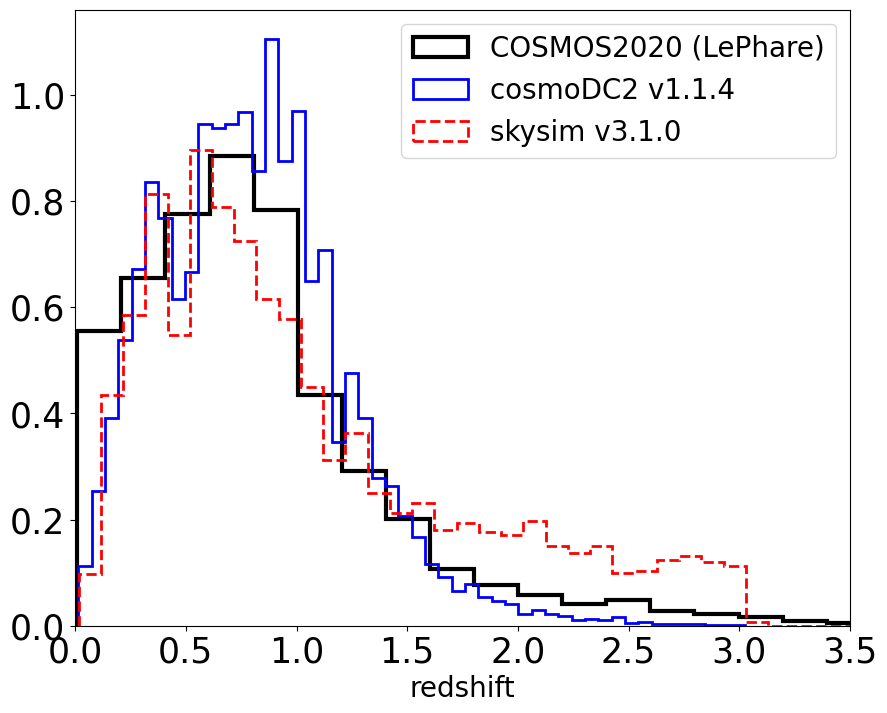

In [33]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25
plt.hist(cosmos2020_lsst_y1['lp_zPDF'], bins=50, lw=3, ls='solid', color='black', histtype='step',density=True, label='COSMOS2020 (LePhare)')
plt.hist(cosmodc2_df_lsst_y1['baseDC2/redshift'], bins=50, lw=2, ls='solid', color='blue', histtype='step',density=True, label='cosmoDC2 v1.1.4')
plt.hist(skysim3_df_lsst_y1['redshift'], bins=50, lw=2, ls='dashed', color='red', histtype='step',density=True, label='skysim v3.1.0')
plt.legend(loc='upper right', fontsize=20)
plt.xlim(0,3.5)
plt.xlabel(r'redshift', fontsize=20)
plt.ylabel(r'', fontsize=20)
plt.show()

#### Stellar mass - Star formation rate plane comparison with Eazy derived physical properties

<Figure size 1000x800 with 0 Axes>

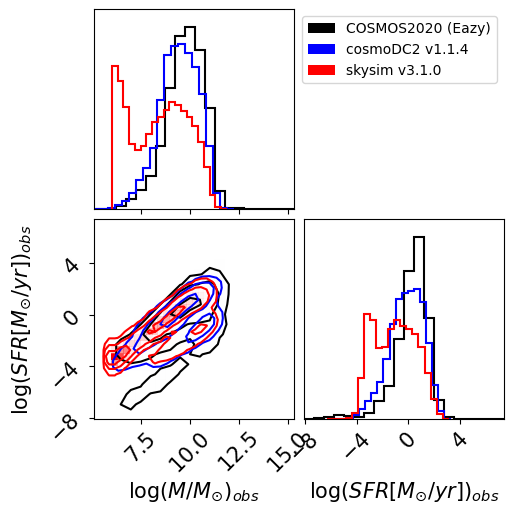

In [34]:
w = np.where((cosmos2020_lsst_y1['ez_mass']>0)&(10**(cosmos2020_lsst_y1['ez_sfr'])>0))
#idxs_cosmos = np.random.randint(0,len(cosmos2020[w]),100000) # 100k random samples
prop_cosmos = np.empty((len(cosmos2020_lsst_y1['ez_mass'][w]), 2))
prop_cosmos[:, 0] = cosmos2020_lsst_y1['ez_mass'][w]
prop_cosmos[:, 1] = cosmos2020_lsst_y1['ez_sfr'][w]

w = np.where((cosmodc2_df_lsst_y1['baseDC2/obs_sm'].values>0)&(cosmodc2_df_lsst_y1['baseDC2/obs_sfr'].values>0))
prop_cosmodc2 = np.empty((len(cosmodc2_df_lsst_y1['baseDC2/obs_sm'].values[w]), 2))
prop_cosmodc2[:, 0] = np.log10(cosmodc2_df_lsst_y1['baseDC2/obs_sm'].values[w])
prop_cosmodc2[:, 1] = np.log10(cosmodc2_df_lsst_y1['baseDC2/obs_sfr'].values[w])

w = np.where((skysim3_df_lsst_y1['obs_sm'].values>0)&(skysim3_df_lsst_y1['obs_sfr'].values>0))
prop_skysim = np.empty((len(skysim3_df_lsst_y1['obs_sm'].values[w]),2))
prop_skysim[:, 0] = np.log10(skysim3_df_lsst_y1['obs_sm'].values[w])
prop_skysim[:, 1] = np.log10(skysim3_df_lsst_y1['obs_sfr'].values[w])

plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(prop_cosmos, hist_kwargs=dict(density=True, linewidth=1.5,), #range=extents,
                    color='black', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(prop_cosmodc2, fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(prop_skysim, fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'black'), 
         plt.Rectangle((0,0),1,1,fc = 'blue'),
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['COSMOS2020 (Eazy)','cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

<Figure size 1000x800 with 0 Axes>

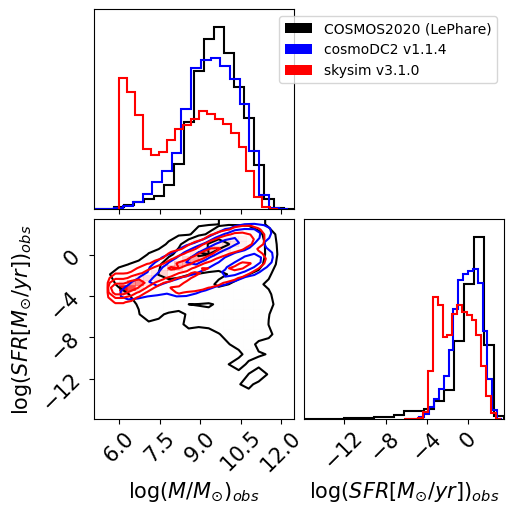

In [35]:
w = np.where((cosmos2020_lsst_y1['lp_mass_med']>0)&(cosmos2020_lsst_y1['lp_SFR_med']>-20))
#idxs_cosmos = np.random.randint(0,len(cosmos2020[w]),100000) # 100k random samples
prop_cosmos_lephare = np.empty((len(cosmos2020_lsst_y1['lp_mass_med'][w]), 2))
prop_cosmos_lephare[:, 0] = cosmos2020_lsst_y1['lp_mass_med'][w]
prop_cosmos_lephare[:, 1] = cosmos2020_lsst_y1['lp_SFR_med'][w]

plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(prop_cosmos_lephare, hist_kwargs=dict(density=True, linewidth=1.5,), #range=extents,
                    color='black', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(prop_cosmodc2, fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(prop_skysim, fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$\log(M/M_{\odot})_{obs}$',r'$\log(SFR[M_{\odot}/yr])_{obs}$'],
                    label_kwargs={"fontsize":15}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'black'), 
         plt.Rectangle((0,0),1,1,fc = 'blue'),
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['COSMOS2020 (LePhare)','cosmoDC2 v1.1.4', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

#### HSC observed-frame magnitudes and colours comparison between COSMOS2020 and skysim v3.1.0

In [36]:
wavebands = ['g', 'r', 'i', 'z', 'y']
hsc_obsframe_mags_skysim = np.array([skysim3_df_lsst_y1['HSC_obs_{}'.format(waveband)].values for waveband in wavebands])
hsc_obsframe_colours_skysim = np.array([skysim3_df_lsst_y1['HSC_obs_{}'.format(wavebands[i])].values-skysim3_df_lsst_y1['HSC_obs_{}'.format(wavebands[i+1])].values for i in range(len(wavebands)-1)])
hsc_obsframe_mags_cosmos = np.array([cosmos2020_lsst_y1['HSC_{}_MAG_AUTO'.format(waveband)] for waveband in wavebands])
hsc_obsframe_colours_cosmos = np.array([cosmos2020_lsst_y1['HSC_{}_MAG_AUTO'.format(wavebands[i])]-cosmos2020_lsst_y1['HSC_{}_MAG_AUTO'.format(wavebands[i+1])] for i in range(len(wavebands)-1)])

<Figure size 1000x800 with 0 Axes>

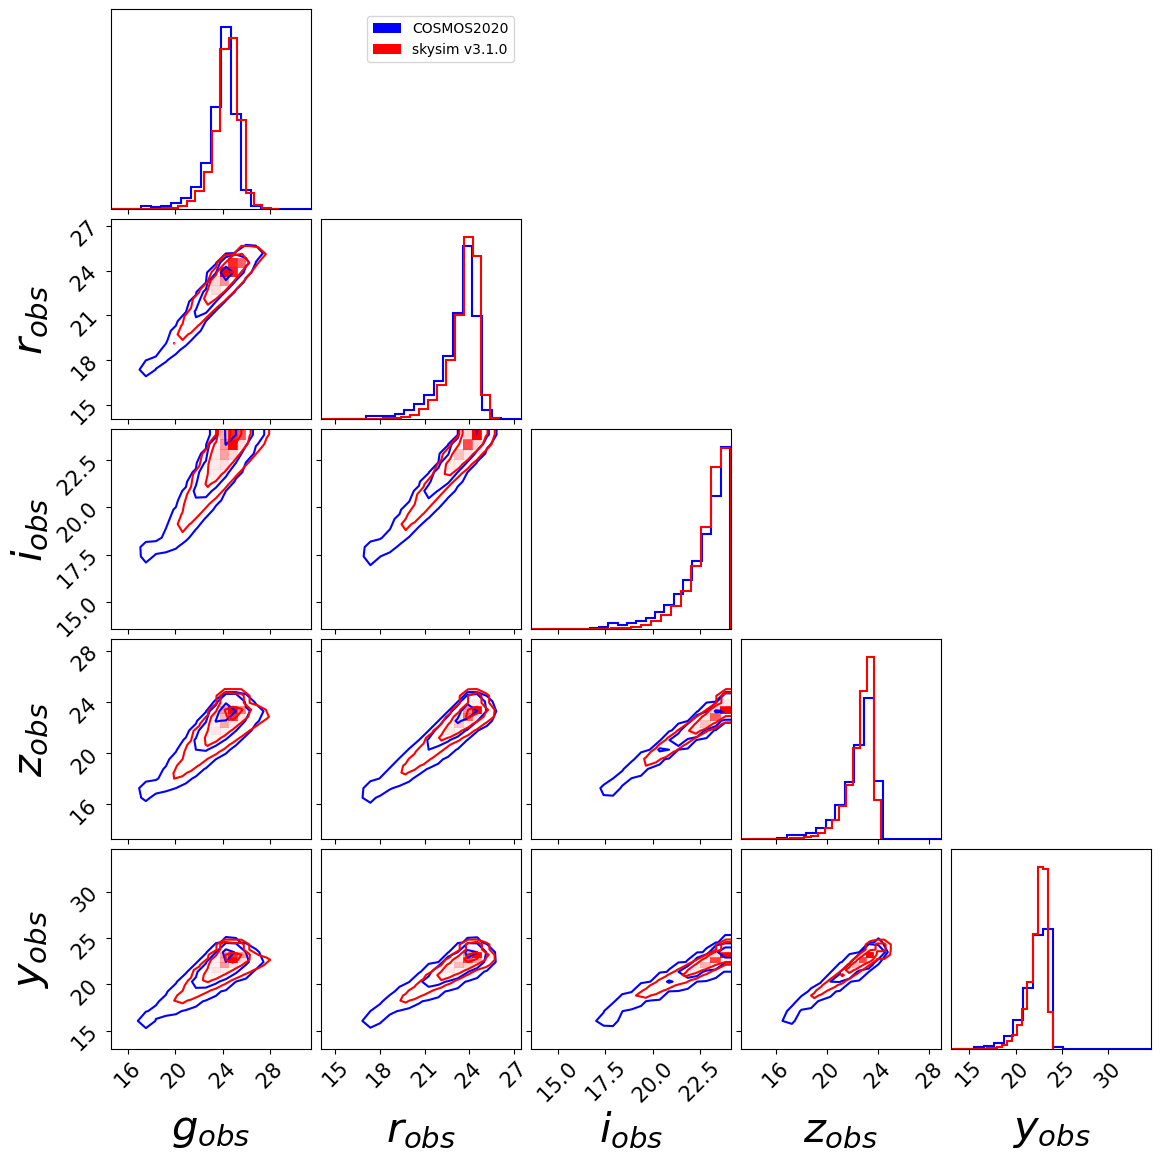

In [37]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = corner.corner(np.swapaxes(hsc_obsframe_mags_cosmos,0,1), hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='blue', labels=[r'$g_{obs}$',r'$r_{obs}$',r'$i_{obs}$',r'$z_{obs}$',r'$y_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(np.swapaxes(hsc_obsframe_mags_skysim,0,1), fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), #range=extents,
                    color='red', labels=[r'$g_{obs}$',r'$r_{obs}$',r'$i_{obs}$',r'$z_{obs}$',r'$y_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['COSMOS2020', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

<Figure size 1000x800 with 0 Axes>

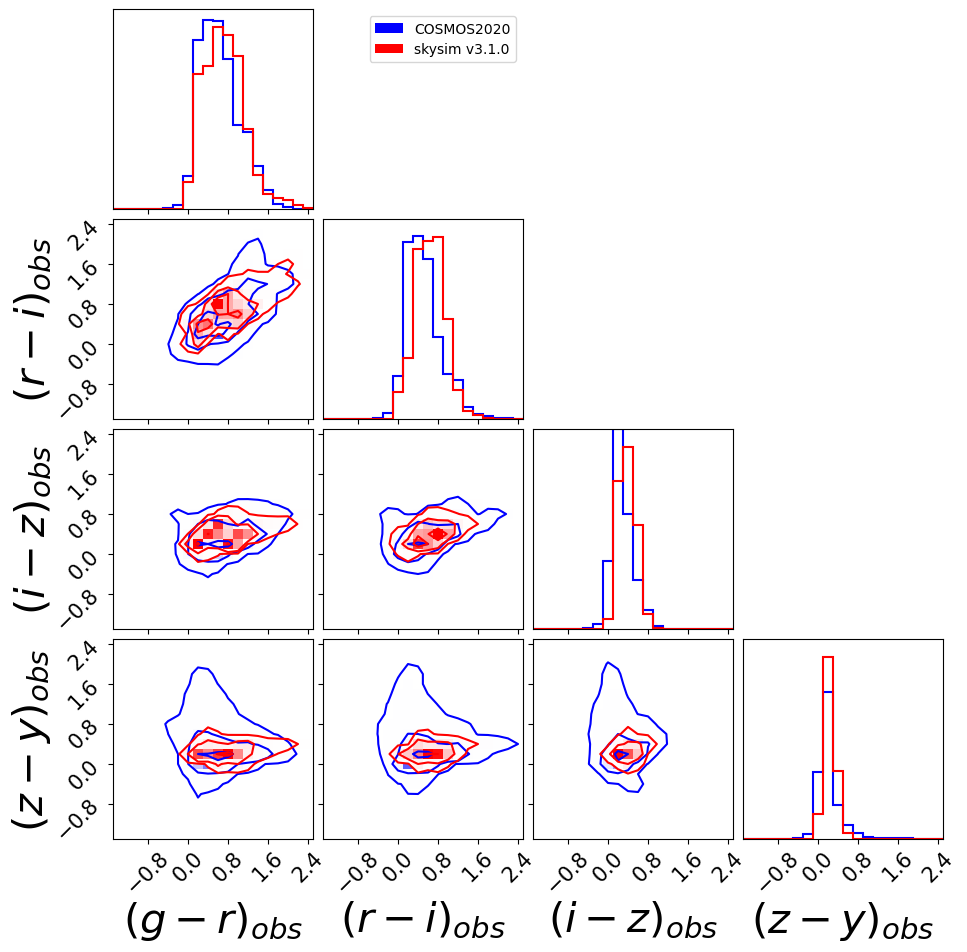

In [40]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

extents=[(-1.5,2.5),(-1.5,2.5),(-1.5,2.5),(-1.5,2.5)]

fig = corner.corner(np.swapaxes(hsc_obsframe_colours_cosmos,0,1), hist_kwargs=dict(density=True, linewidth=1.5), range=extents,
                    color='blue', labels=[r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(np.swapaxes(hsc_obsframe_colours_skysim,0,1), fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), range=extents,
                    color='red', labels=[r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$'],
                    label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]
axes[1].legend(proxy, ['COSMOS2020', 'skysim v3.1.0'],loc='upper right',fontsize=10)
plt.show()

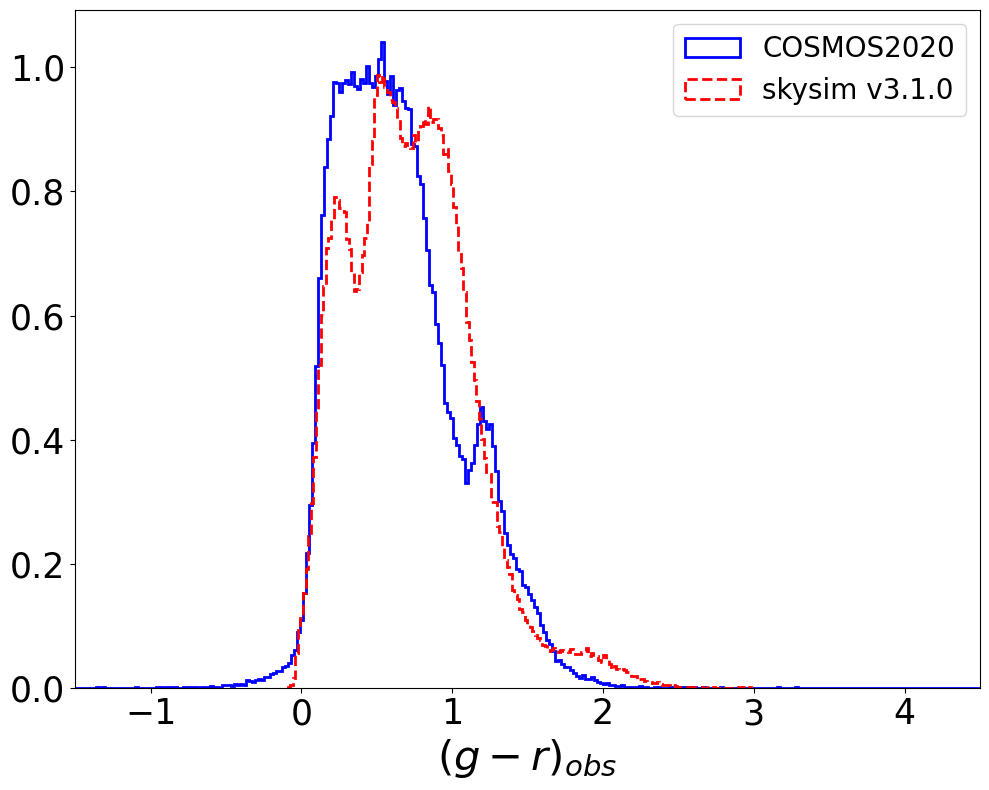

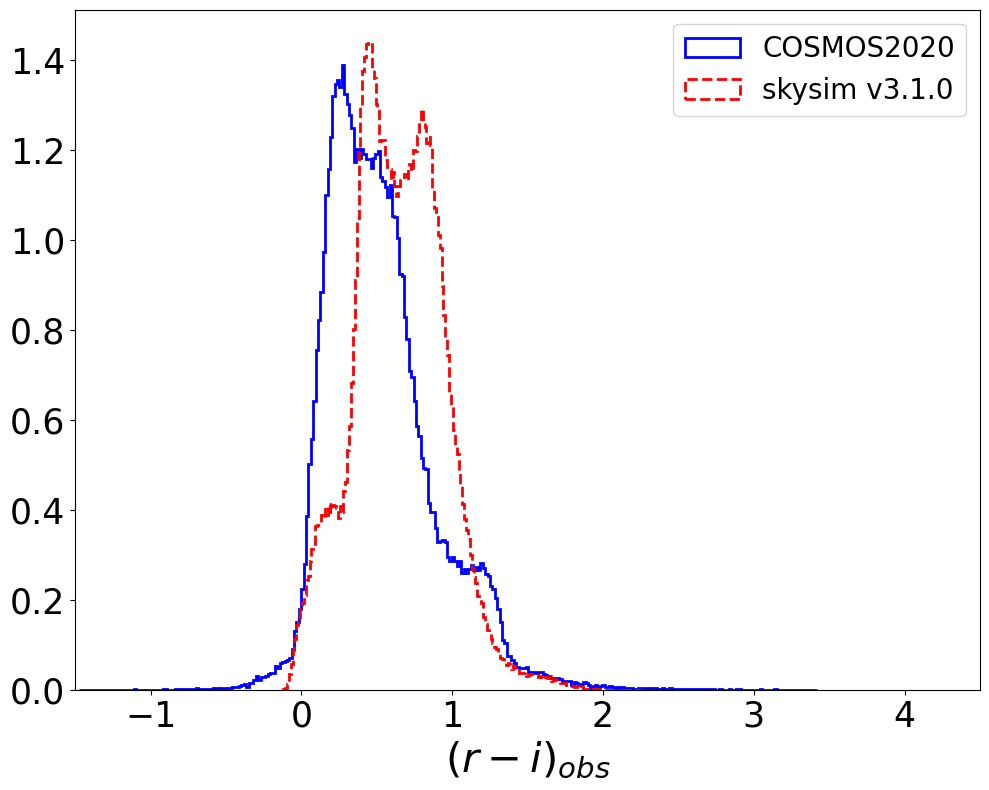

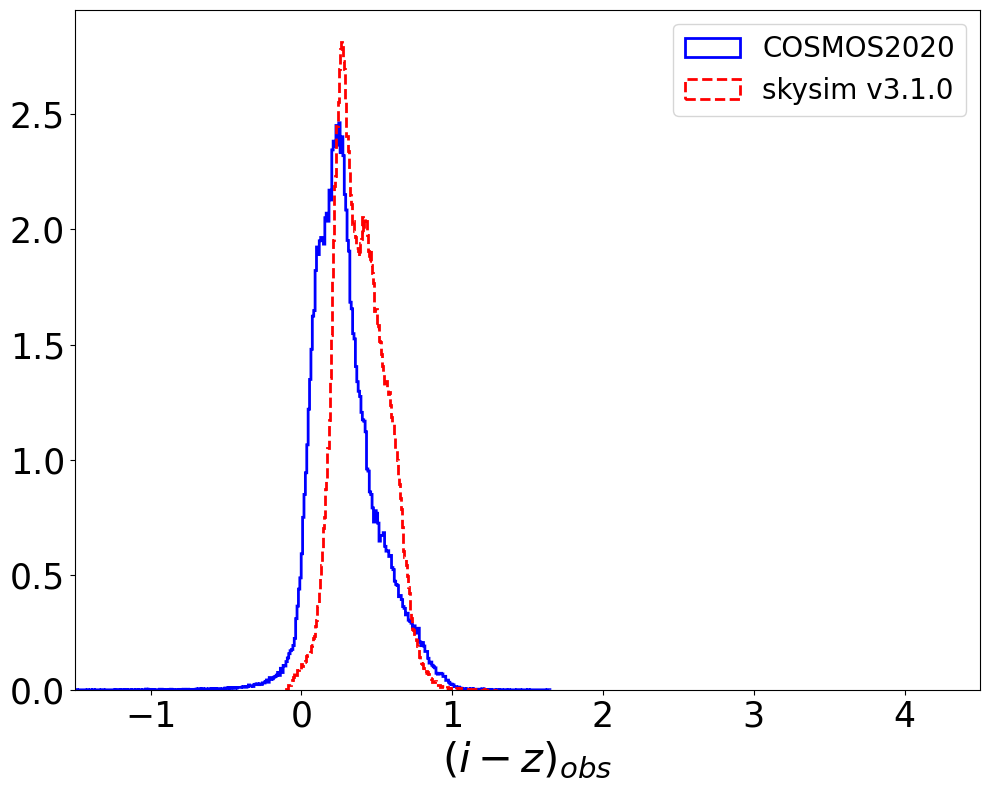

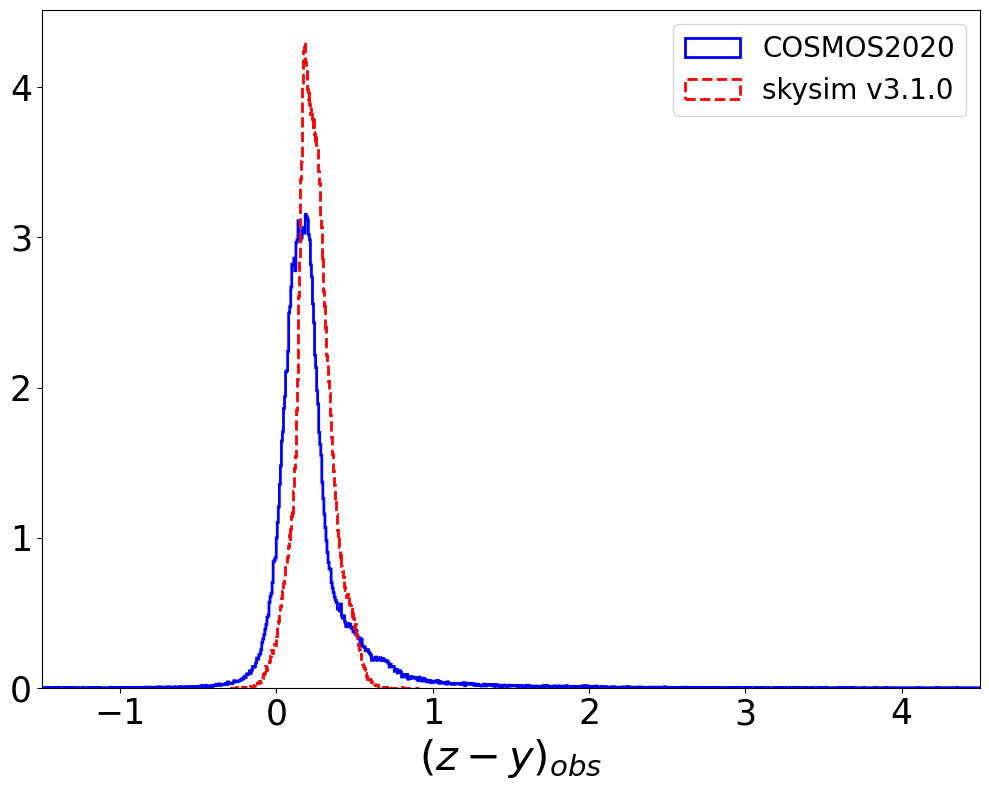

In [41]:
colours = [r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$']
for i in range(len(colours)):
    plt.clf()
    plt.rcParams['figure.figsize']=(10,8)
    plt.rcParams['xtick.labelsize']=25
    plt.rcParams['ytick.labelsize']=25
    plt.hist(hsc_obsframe_colours_cosmos[i,:], bins='auto', lw=2, ls='solid', color='blue', histtype='step',density=True, label='COSMOS2020')
    plt.hist(hsc_obsframe_colours_skysim[i,:], bins='auto', lw=2, ls='dashed', color='red', histtype='step',density=True, label='skysim v3.1.0')
    plt.legend(loc='upper right', fontsize=20)
    plt.xlim(-1.5,4.5)
    plt.xlabel(colours[i], fontsize=30)
    plt.ylabel(r'', fontsize=20)
    plt.tight_layout()
    plt.show()

#### Observed color-redshift relation comparison between COSMOS2020 and skysim v3.1.0

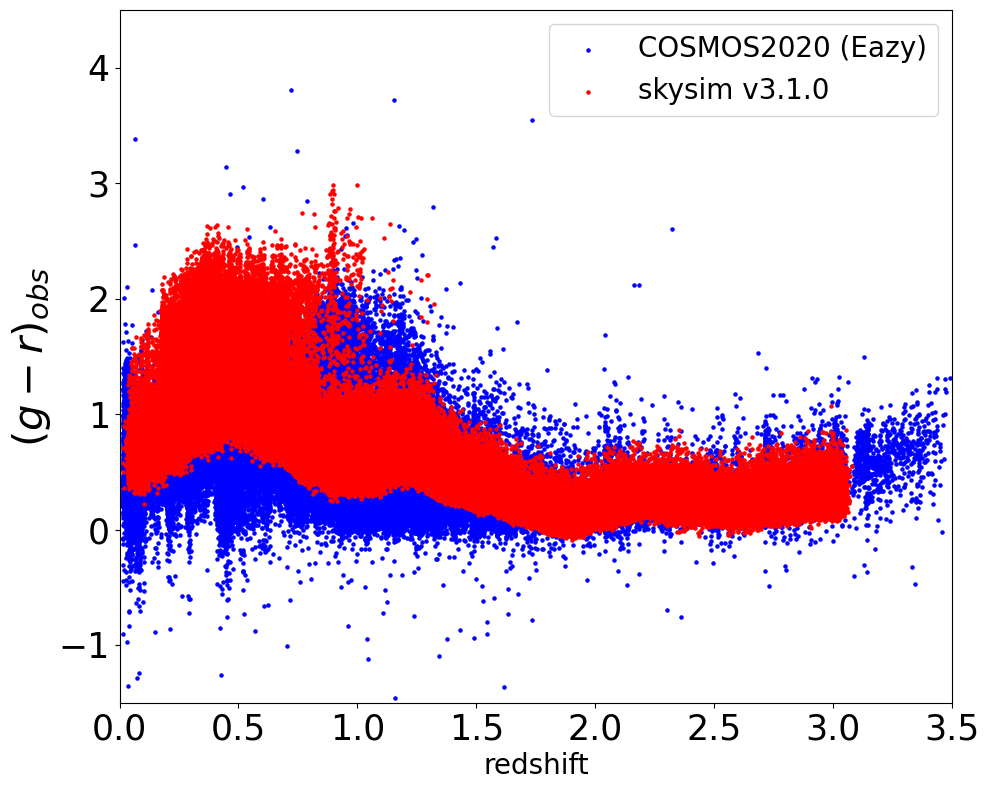

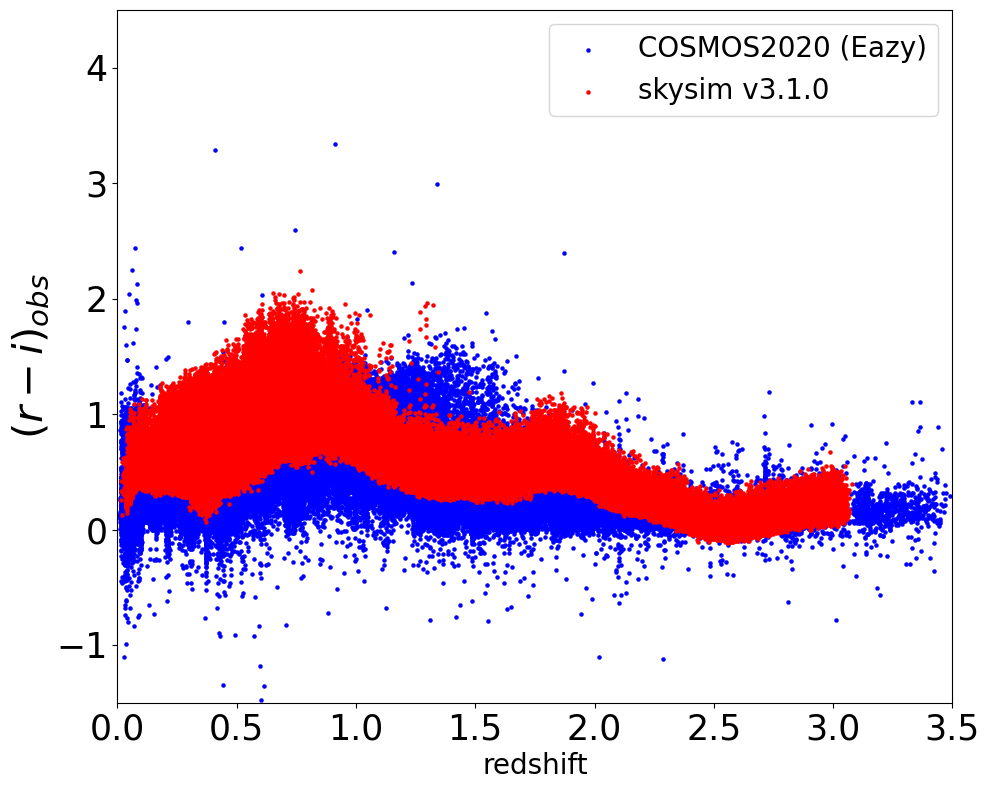

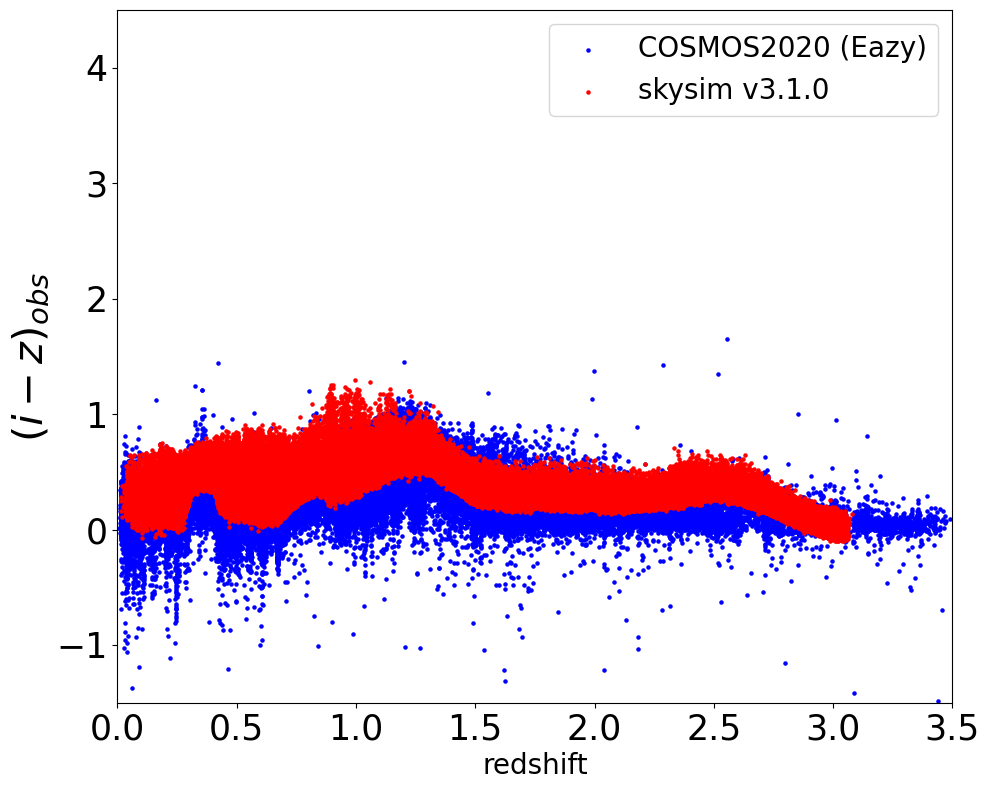

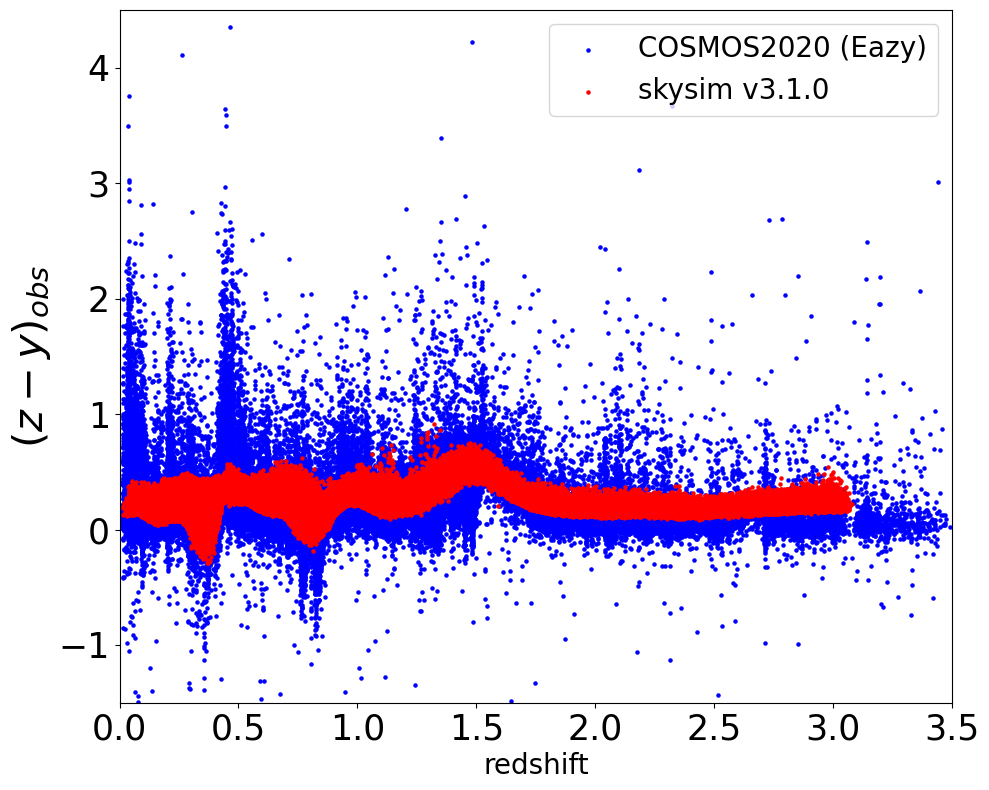

In [44]:
colours = [r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$']
for i in range(len(colours)):
    plt.clf()
    plt.rcParams['figure.figsize']=(10,8)
    plt.rcParams['xtick.labelsize']=25
    plt.rcParams['ytick.labelsize']=25
    plt.scatter(cosmos2020_lsst_y1['ez_z_phot'], hsc_obsframe_colours_cosmos[i,:], s=5, color='blue', label='COSMOS2020 (Eazy)')
    plt.scatter(skysim3_df_lsst_y1['redshift'], hsc_obsframe_colours_skysim[i,:], s=5, color='red', label='skysim v3.1.0')
    plt.legend(loc='upper right', fontsize=20)
    plt.xlim(0,3.5)
    plt.ylim(-1.5,4.5)
    plt.ylabel(colours[i], fontsize=30)
    plt.xlabel(r'redshift', fontsize=20)
    plt.tight_layout()
    plt.show()

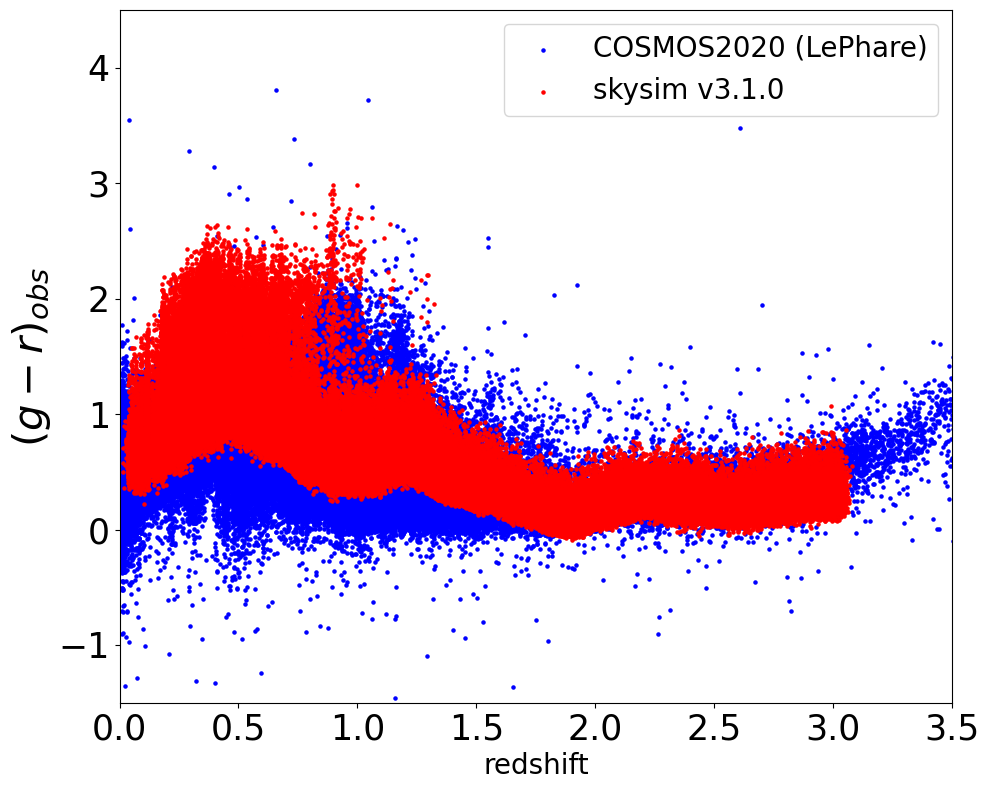

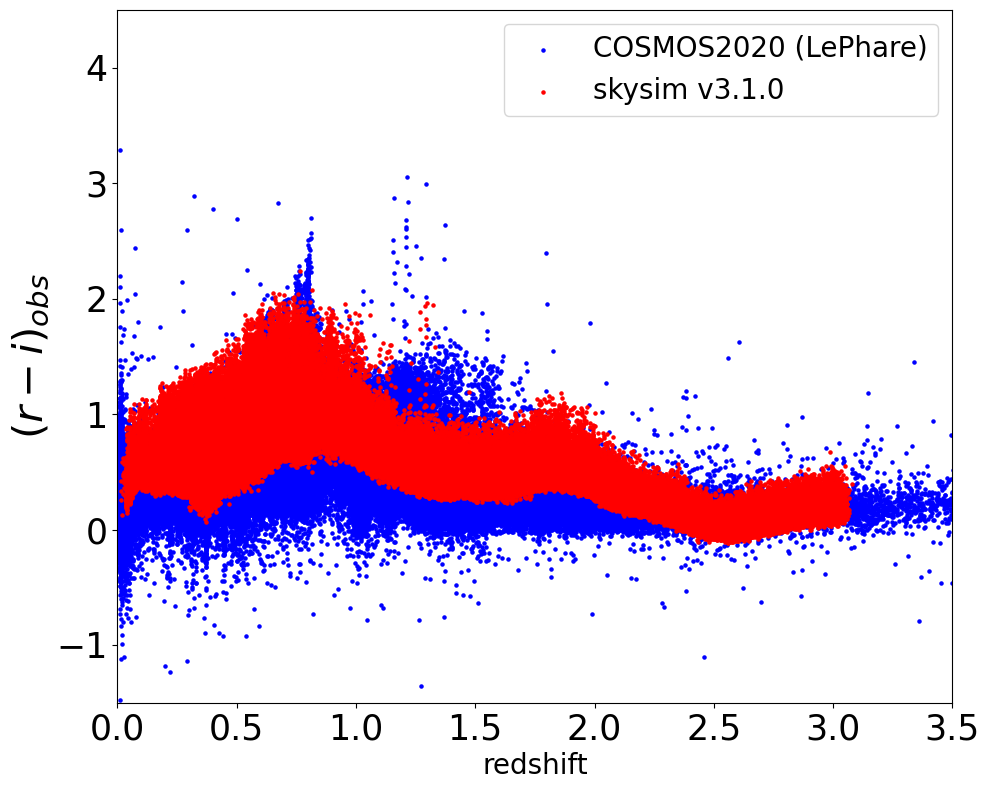

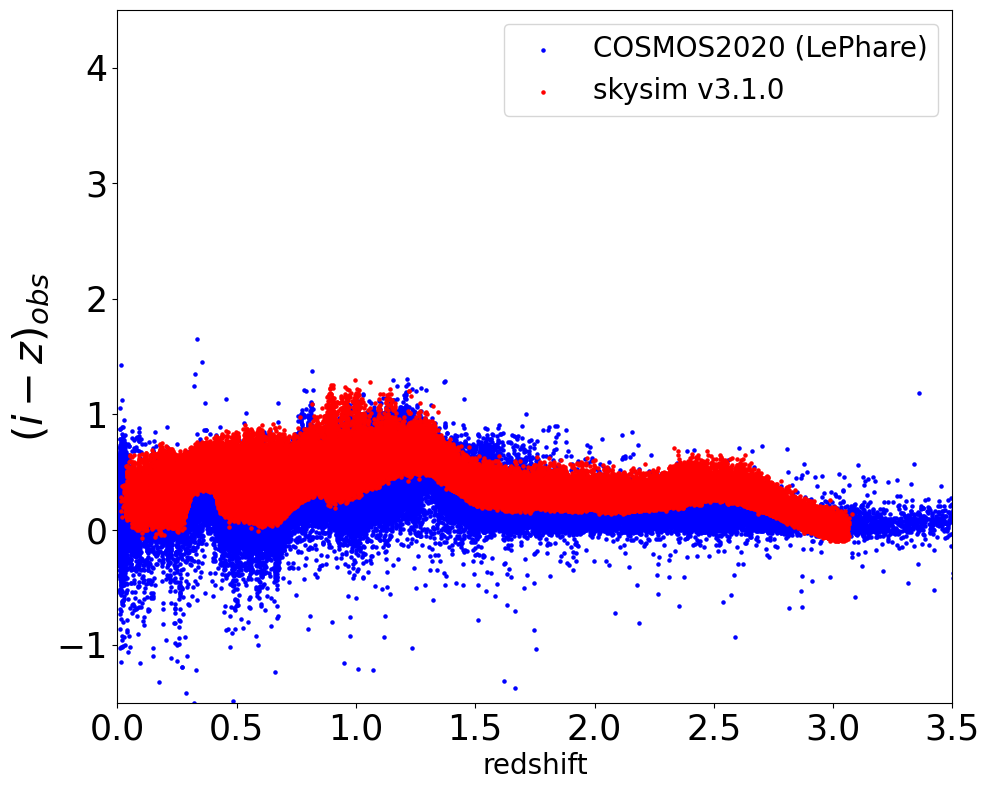

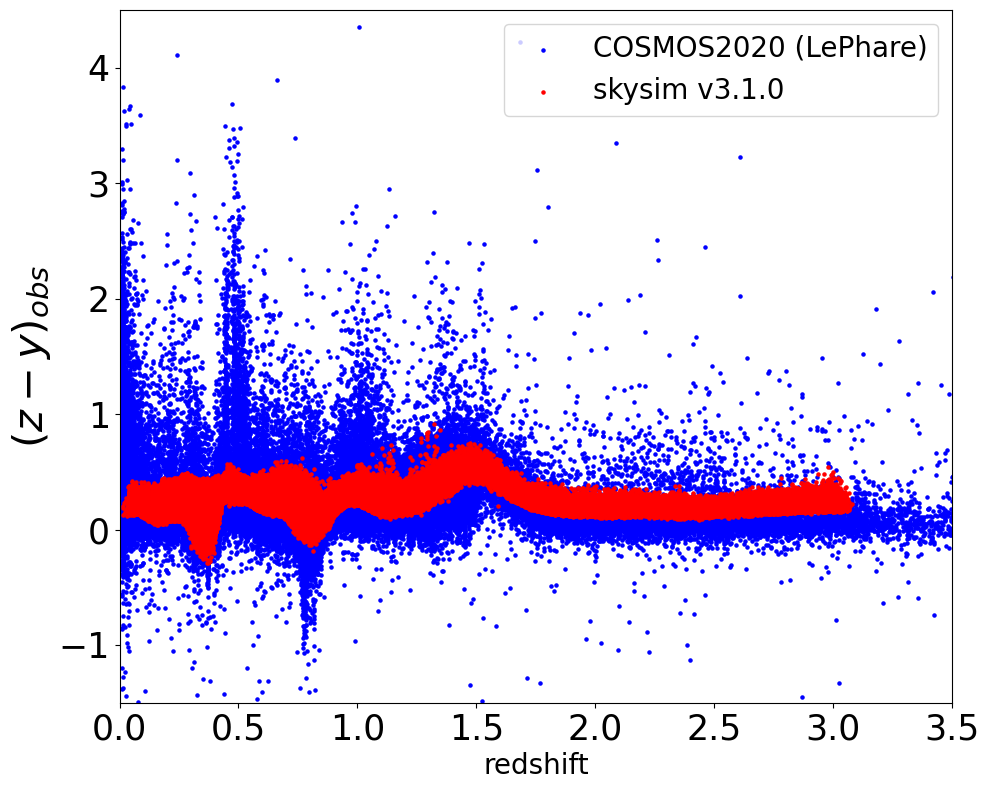

In [45]:
colours = [r'$(g-r)_{obs}$',r'$(r-i)_{obs}$',r'$(i-z)_{obs}$',r'$(z-y)_{obs}$']
for i in range(len(colours)):
    plt.clf()
    plt.rcParams['figure.figsize']=(10,8)
    plt.rcParams['xtick.labelsize']=25
    plt.rcParams['ytick.labelsize']=25
    plt.scatter(cosmos2020_lsst_y1['lp_zPDF'], hsc_obsframe_colours_cosmos[i,:], s=5, color='blue', label='COSMOS2020 (LePhare)')
    plt.scatter(skysim3_df_lsst_y1['redshift'], hsc_obsframe_colours_skysim[i,:], s=5, color='red', label='skysim v3.1.0')
    plt.legend(loc='upper right', fontsize=20)
    plt.xlim(0,3.5)
    plt.ylim(-1.5,4.5)
    plt.ylabel(colours[i], fontsize=30)
    plt.xlabel(r'redshift', fontsize=20)
    plt.tight_layout()
    plt.show()

## Load an hdf5 table of rest-frame spectra generated with rail_fsps and rail_dsps using skysim v3.1.0 input properties

In [47]:
output_directory = os.getcwd()

os.system('curl -O https://portal.nersc.gov/cfs/lsst/schmidt9/skysim_v3.1.0_100k.csv '
          '--output-dir {}'.format(output_directory))

os.system('curl -O https://portal.nersc.gov/cfs/lsst/schmidt9/skysim_v3.1.0_sed_library.h5 '
          '--output-dir {}'.format(output_directory))

In [48]:
skysim_for_seds_df = pd.read_csv(os.path.join(output_directory, 'skysim_v3.1.0_100k.csv'))

In [49]:
with h5py.File(os.path.join(output_directory, 'skysim_v3.1.0_sed_library.h5'), 'r') as h5table:
    idx = h5table['index'][()]
    fsps_ab_magnitudes = h5table['fsps_ab_magnitudes'][()]
    fsps_rest_wavelength_A = h5table['fsps_rest_wavelength_A'][()]
    fsps_rest_Lsolar_Hz = h5table['fsps_rest_Lsolar_Hz'][()]
    dsps_ab_magnitudes = h5table['dsps_ab_magnitudes'][()]
    dsps_rest_wavelength_A = h5table['dsps_rest_wavelength_A'][()]
    dsps_rest_Lsolar_Hz = h5table['dsps_rest_Lsolar_Hz'][()]
    filters_list = [name.decode('utf8') for name in h5table['filters_list'][()]]

In [53]:
print(filters_list)

['cfhtls_u', 'cfhtls_g', 'cfhtls_r', 'cfhtls_i', 'cfhtls_z', 'cfht_megacam_us_9301', 'cfht_megacam_gs_9401', 'cfht_megacam_rs_9601', 'cfht_megacam_is_9701', 'cfht_megacam_zs_9801', 'cfht_wircam_H_8201', 'cfht_wircam_J_8101', 'cfht_wircam_Ks_8302', 'hsc_g', 'hsc_r', 'hsc_i', 'hsc_z', 'hsc_y', 'lsst_u_transmission', 'lsst_g_transmission', 'lsst_r_transmission', 'lsst_i_transmission', 'lsst_z_transmission', 'lsst_y_transmission', 'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0', 'vista_vircam_Z', 'vista_vircam_Y', 'vista_vircam_J', 'vista_vircam_H', 'vista_vircam_Ks']


#### Comparison of rest-frame spectra generated with FSPS and DSPS on the same input skysim v3.1.0 galaxy properties

In [ ]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25

mask_fsps = np.where((fsps_rest_wavelength_A>=3500) & (fsps_rest_wavelength_A<=10000))
mask_dsps = np.where((dsps_rest_wavelength_A>=3500) & (dsps_rest_wavelength_A<=10000))

plt.plot(fsps_rest_wavelength_A[mask_fsps], np.nanmedian(fsps_rest_Lsolar_Hz,axis=0)[mask_fsps], 
         lw=3, color='red', label='FSPS')
plt.plot(dsps_rest_wavelength_A[mask_dsps], np.nanmedian(dsps_rest_Lsolar_Hz,axis=0)[mask_dsps], 
         lw=1, color='green', label='DSPS')

plt.legend(loc='upper right', fontsize=20)
plt.xlabel(r'Wavelength [$\AA$]', fontsize=20)
plt.ylabel(r'luminosity density $L_{\nu} [\mathrm{L_{\odot} Hz^{-1}}]$', fontsize=20)
plt.tight_layout()
plt.xlim(3000,10000)
#plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
frac_diff_dspsvsfsps_wrt_fsps = abs((dsps_rest_Lsolar_Hz-fsps_rest_Lsolar_Hz))/fsps_rest_Lsolar_Hz

fifty_percent = np.percentile(frac_diff_dspsvsfsps_wrt_fsps, 50, axis=0,method="closest_observation") 
fifty_percent_idx = np.where(frac_diff_dspsvsfsps_wrt_fsps == fifty_percent)

sixtyeight_percent = np.percentile(frac_diff_dspsvsfsps_wrt_fsps,68,axis=0,method="closest_observation") 
sixtyeight_percent_idx = np.where(frac_diff_dspsvsfsps_wrt_fsps == sixtyeight_percent)

ninetyfive_percent = np.percentile(frac_diff_dspsvsfsps_wrt_fsps,95,axis=0,method="closest_observation") 
ninetyfive_percent_idx = np.where(frac_diff_dspsvsfsps_wrt_fsps == ninetyfive_percent)

ninetynine_percent = np.percentile(frac_diff_dspsvsfsps_wrt_fsps,99,axis=0,method="closest_observation") 
ninetynine_percent_idx = np.where(frac_diff_dspsvsfsps_wrt_fsps == ninetynine_percent)

In [ ]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25

mask_dsps = np.where((dsps_rest_wavelength_A>=3500) & (dsps_rest_wavelength_A<=10000))

plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 fifty_percent[mask_dsps], 
                 facecolor="darkred",label='50%')
plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 sixtyeight_percent[mask_dsps], 
                 facecolor="red", alpha=0.7,label='68%')
plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 ninetyfive_percent[mask_dsps], 
                 facecolor="salmon", alpha=0.5,label='95%')
plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 ninetynine_percent[mask_dsps], 
                 facecolor="mistyrose", alpha=0.5,label='99%')

emission_lines_names = [r'$\mathrm{OII_{doublet}}$',r'$\mathrm{H_{\beta}}$', r'$\mathrm{OII_1}$+$\mathrm{OIII_2}$', 
                        r'$\mathrm{NII_1}$+$\mathrm{H_{\alpha}}$+$\mathrm{NII_2}$',
                        r'$\mathrm{SII_1}$+$\mathrm{SII_2}$',r'$\mathrm{SIII_{12}}$',r'$\mathrm{SIII_{22}}$']
emission_lines_wavelengths = [3726,4861, 4983, 6562, 6725, 9068, 9531]
colours_emlines = ['purple','blue', 'green', 'orange', 'red', 'magenta', 'pink']
lower_lim_emlines_wave = [3680, 4800, 4950, 6500, 6680, 9018, 9480]
upper_lim_emlines_wave = [3780, 4900, 5050, 6600, 6780, 9108, 9580]
y_coord_emlines = [0.07,0.09,0.07,0.09,0.07,0.09,0.07]
for k in range(len(emission_lines_wavelengths)):
    plt.vlines(lower_lim_emlines_wave[k], ymin=0, ymax=0.3, color='black', lw=2)
    plt.vlines(upper_lim_emlines_wave[k], ymin=0, ymax=0.3, color='black', lw=2)
    plt.text(lower_lim_emlines_wave[k]+50, y_coord_emlines[k], emission_lines_names[k], fontsize=20)
    plt.fill_betweenx(np.arange(0,0.31,0.01), lower_lim_emlines_wave[k], upper_lim_emlines_wave[k],
                      alpha=0.3, color=colours_emlines[k])

    
plt.legend(loc='center right', fontsize=20)
plt.xlabel(r'Wavelength [$\AA$]', fontsize=20)
plt.ylabel(r'|DSPS-FSPS|/FSPS', fontsize=20)
plt.tight_layout()
plt.xlim(3000,10000)
plt.yscale('log')
plt.show()

In [ ]:
plt.clf()
plt.rcParams['figure.figsize']=(10,8)
plt.rcParams['xtick.labelsize']=25
plt.rcParams['ytick.labelsize']=25

mask_dsps = np.where(dsps_rest_wavelength_A<=20000)

plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 fifty_percent[mask_dsps], 
                 facecolor="darkred",label='50%')
plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 sixtyeight_percent[mask_dsps], 
                 facecolor="red", alpha=0.7,label='68%')
plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 ninetyfive_percent[mask_dsps], 
                 facecolor="salmon", alpha=0.5,label='95%')
plt.fill_between(dsps_rest_wavelength_A[mask_dsps], np.full(len(dsps_rest_wavelength_A[mask_dsps]), 0), 
                 ninetynine_percent[mask_dsps], 
                 facecolor="mistyrose", alpha=0.5,label='99%')
    
plt.legend(loc='center right', fontsize=20)
plt.xlabel(r'Wavelength [$\AA$]', fontsize=20)
plt.ylabel(r'|DSPS-FSPS|/FSPS', fontsize=20)
plt.tight_layout()
plt.xlim(80,20000)
plt.xscale('log')
plt.yscale('log')
plt.show()

#### Comparison of optical and infrared colours between COSMOS2020 and those obtained via DSPS 

In [59]:
skysim_mags_names = ['cfhtls_u','hsc_g', 'hsc_r', 'hsc_i', 'hsc_z', 'hsc_y','vista_vircam_J', 'vista_vircam_H',
                     'vista_vircam_Ks']
cosmos_mags_names = ['CFHT_u_MAG_AUTO','HSC_g_MAG_AUTO','HSC_r_MAG_AUTO','HSC_i_MAG_AUTO','HSC_z_MAG_AUTO',
                     'HSC_y_MAG_AUTO','UVISTA_J_MAG_AUTO','UVISTA_H_MAG_AUTO','UVISTA_Ks_MAG_AUTO']

In [62]:
dsps_colors = np.empty((len(dsps_ab_magnitudes), 8))
cosmos2020_colors = np.empty((len(cosmos2020), 8))

In [63]:
for i in range(len(skysim_mags_names)-1):
    idx_mag1 = filters_list.index(skysim_mags_names[i])
    idx_mag2 = filters_list.index(skysim_mags_names[i+1])
    dsps_colors[:, i] = dsps_ab_magnitudes[:, idx_mag1] - dsps_ab_magnitudes[:, idx_mag2]
    cosmos2020_colors[:,i] = cosmos2020[cosmos_mags_names[i]] - cosmos2020[cosmos_mags_names[i+1]]

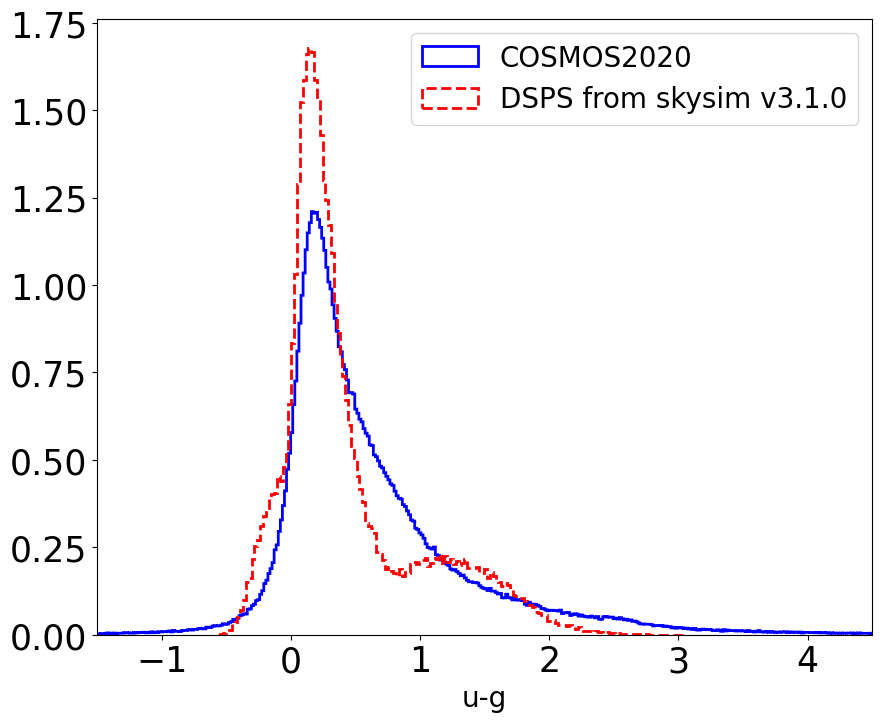

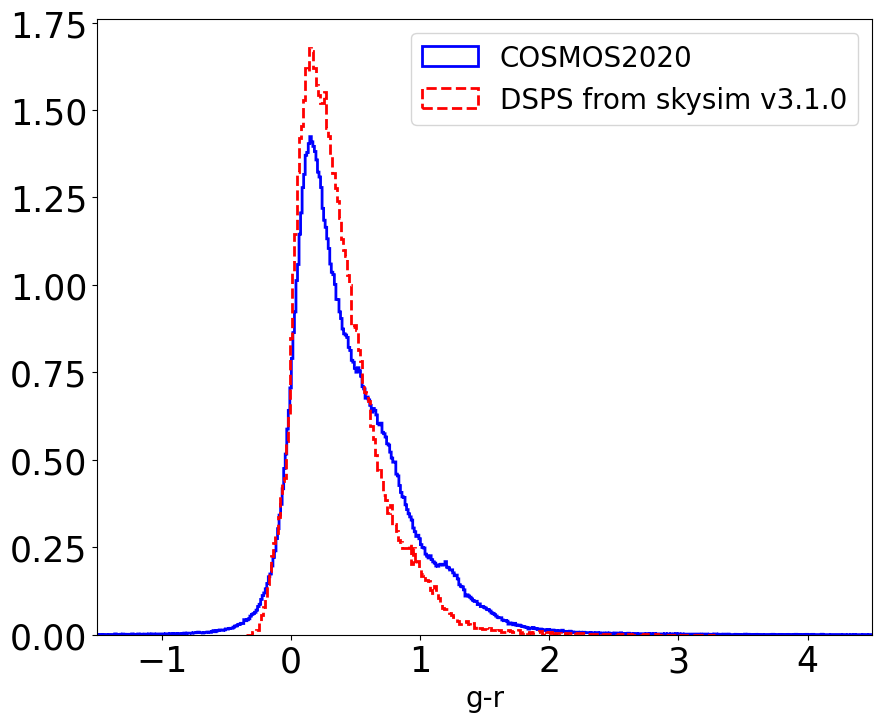

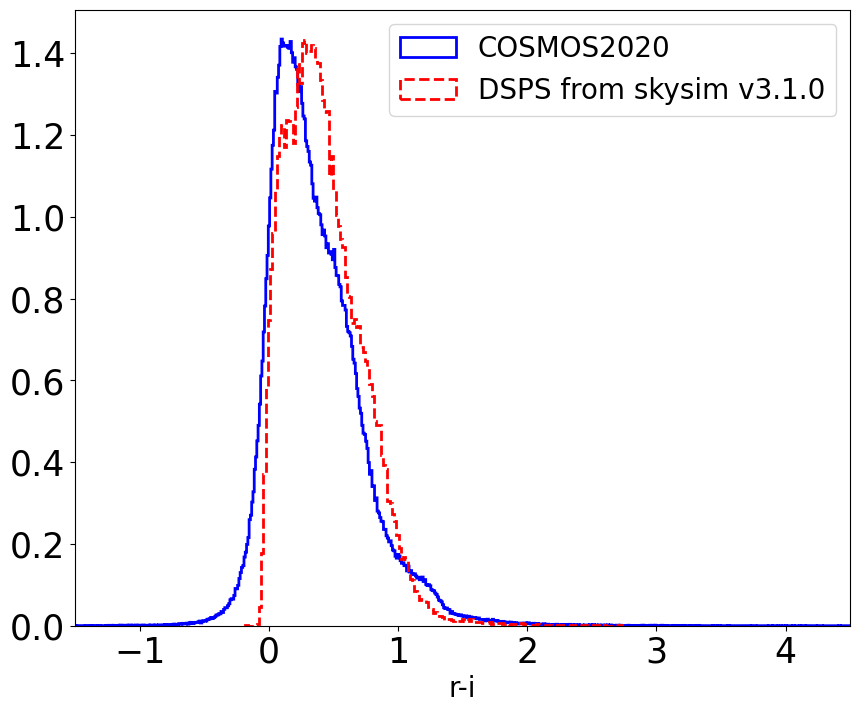

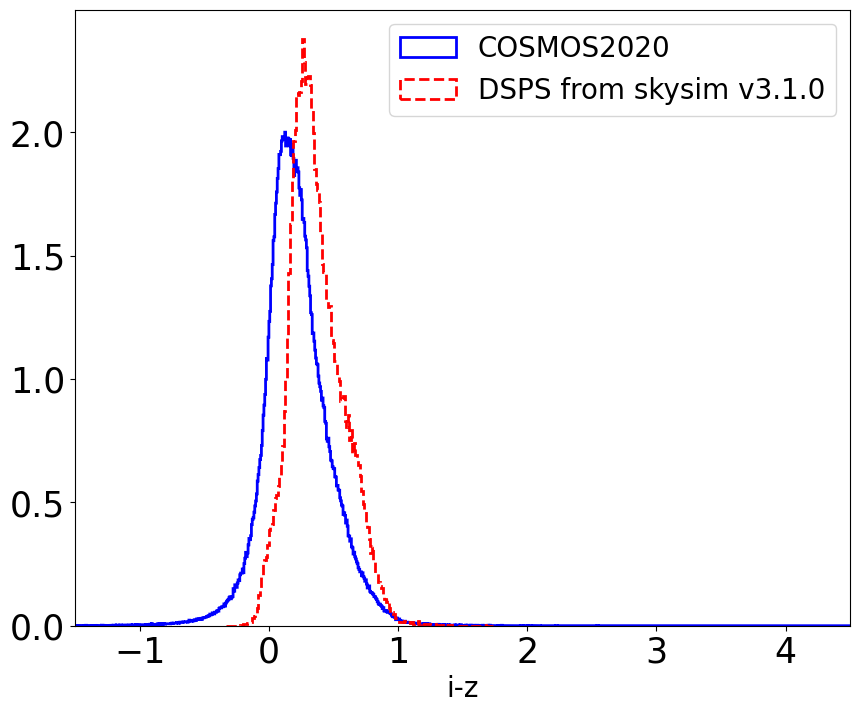

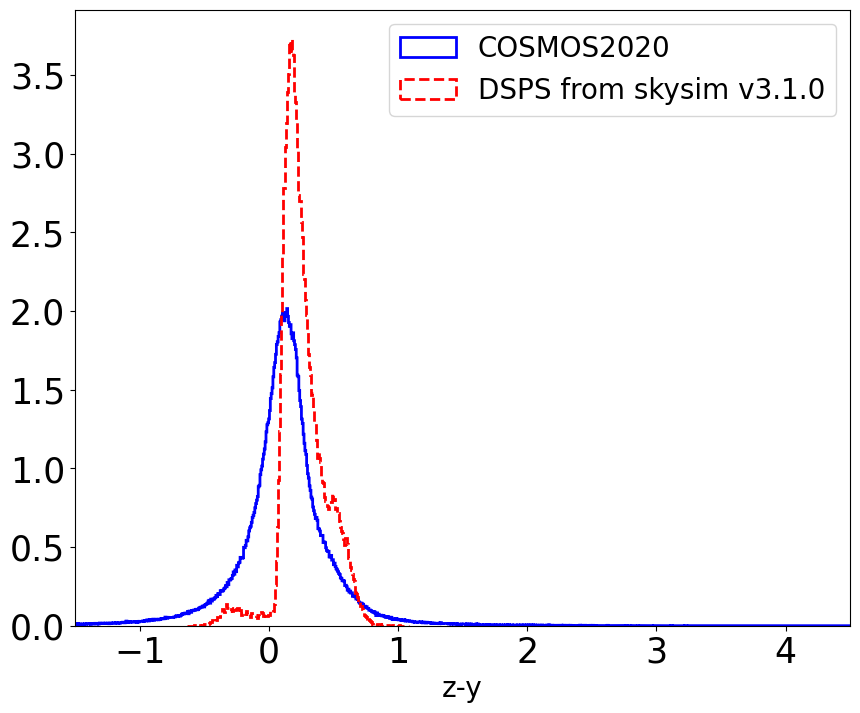

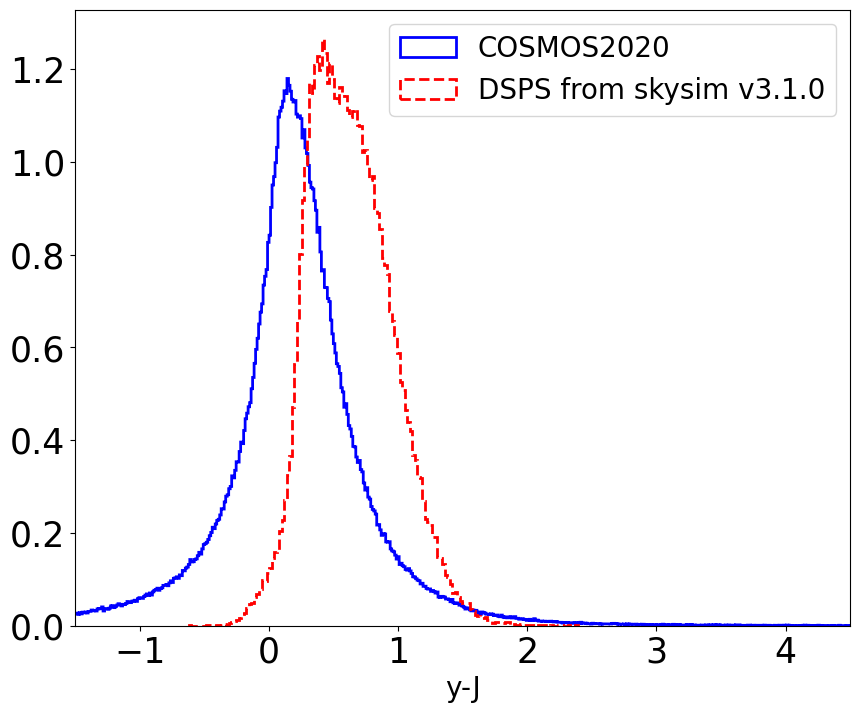

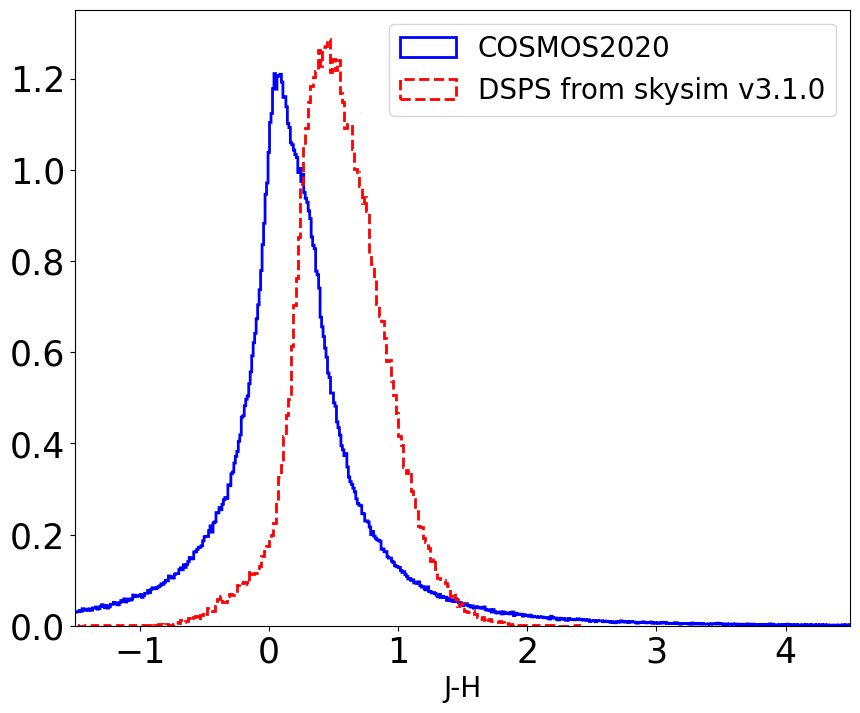

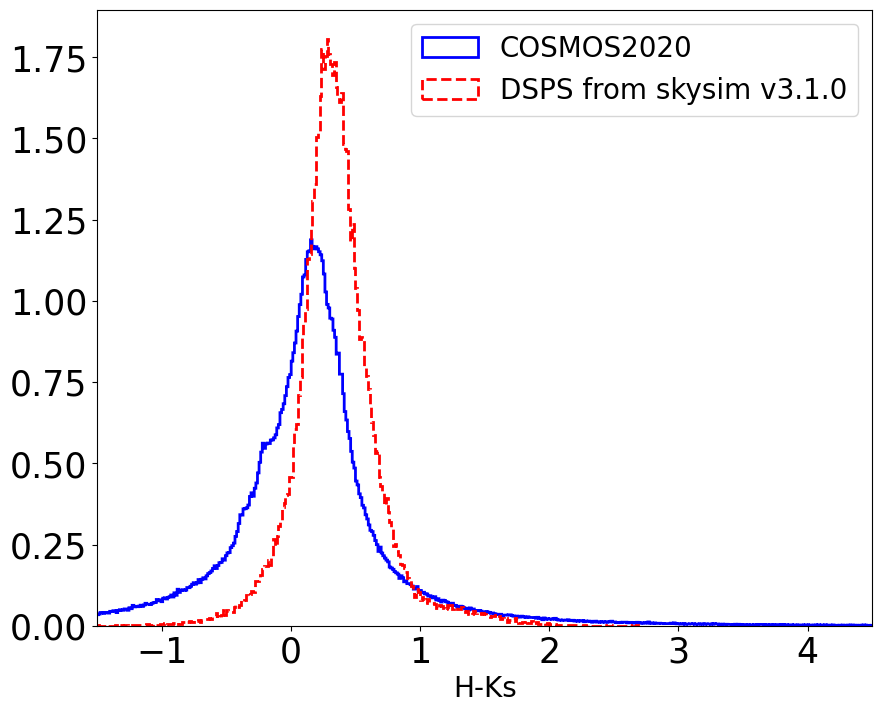

In [65]:
colours = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y', 'y-J', 'J-H', 'H-Ks']

for i in range(len(colours)):
    plt.clf()
    plt.rcParams['figure.figsize']=(10,8)
    plt.rcParams['xtick.labelsize']=25
    plt.rcParams['ytick.labelsize']=25
    
    plt.hist(cosmos2020_colors[:,i], bins='auto', lw=2, ls='solid', color='blue', histtype='step',density=True, label='COSMOS2020')
    plt.hist(dsps_colors[:,i], bins='auto', lw=2, ls='dashed', color='red', histtype='step',density=True, label='DSPS from skysim v3.1.0')
    
    plt.legend(loc='upper right', fontsize=20)
    plt.xlim(-1.5,4.5)
    plt.xlabel(colours[i], fontsize=20)
    plt.ylabel(r'', fontsize=20)
    plt.show()

<Figure size 1000x800 with 0 Axes>

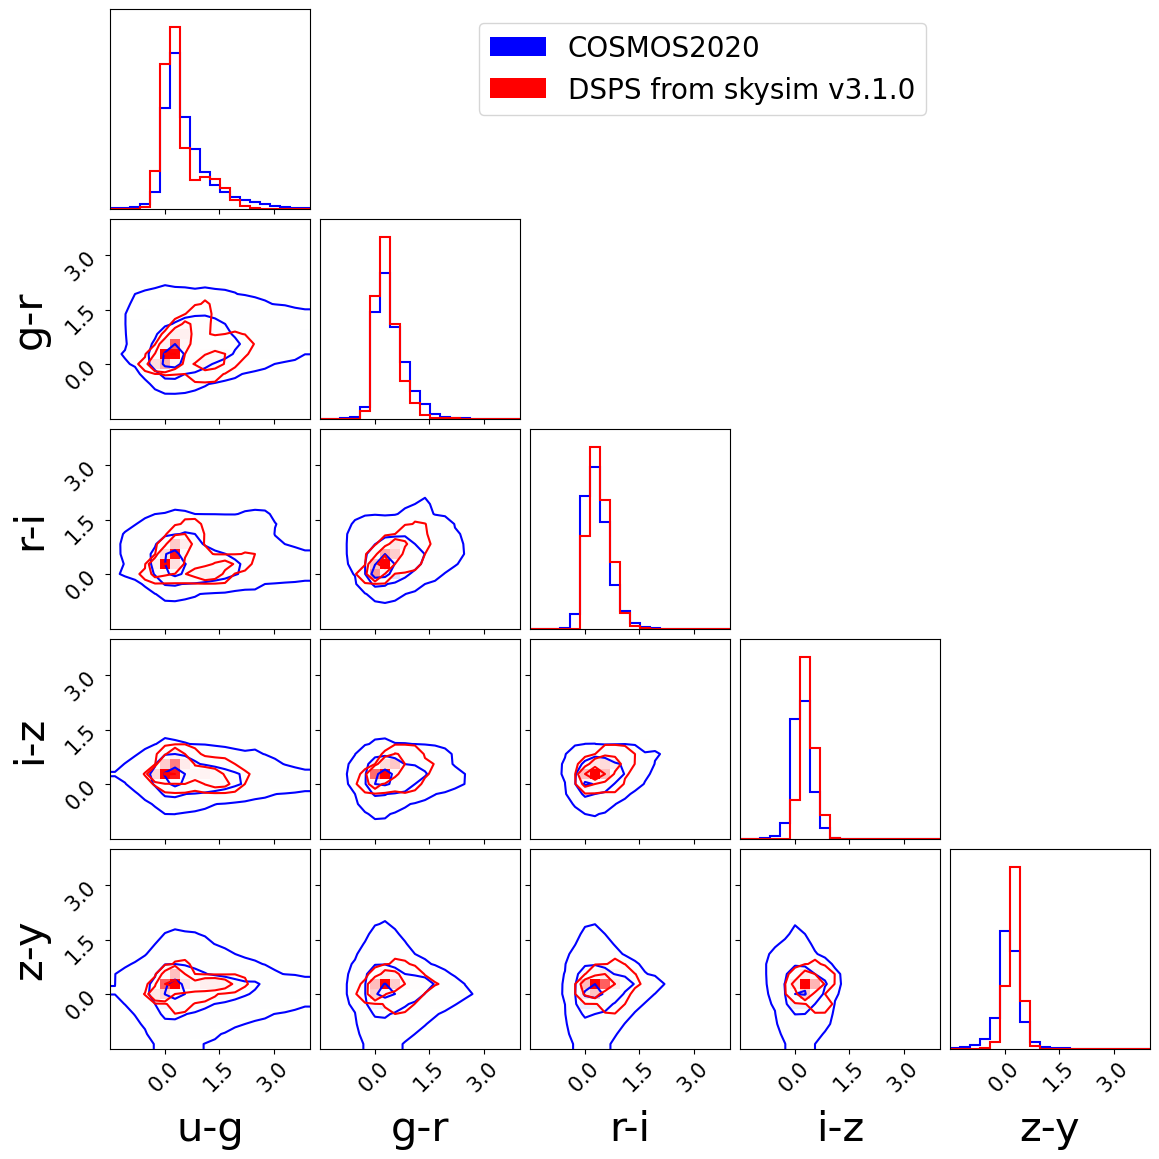

In [68]:
plt.clf()

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

extents = [(-1.5,4.), (-1.5,4.), (-1.5,4.), (-1.5,4.),(-1.5,4.)]

fig = corner.corner(cosmos2020_colors[:,:5], hist_kwargs=dict(density=True, linewidth=1.5), range=extents,
                    color='blue', labels=colours[:5], label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(dsps_colors[:,:5], fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), range=extents,
                    color='red', labels=colours[:5], label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
                    
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]

axes[3].legend(proxy, ['COSMOS2020','DSPS from skysim v3.1.0'],loc='upper right',fontsize=20)

plt.show()

ValueError: Dimension mismatch between samples and range

<Figure size 1000x800 with 0 Axes>

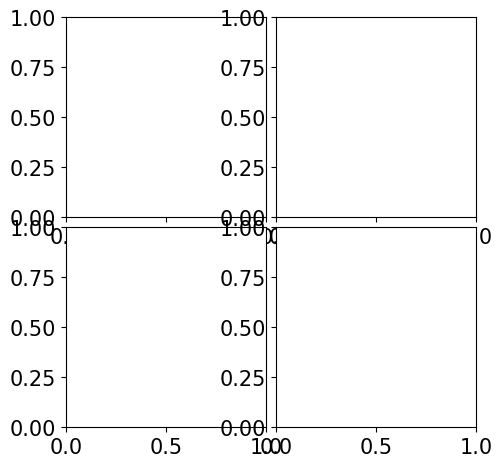

In [69]:
plt.clf()

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

extents = [(-1.5,4.), (-1.5,4.), (-1.5,4.)]

fig = corner.corner(cosmos2020_colors[:,5:], hist_kwargs=dict(density=True, linewidth=1.5), range=extents,
                    color='blue', labels=colours[5:], label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
fig = corner.corner(dsps_colors[:,5:], fig=fig, hist_kwargs=dict(density=True, linewidth=1.5), range=extents,
                    color='red', labels=colours[5:], label_kwargs={"fontsize":30}, use_math_text=True,
                    plot_datapoints=False, levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), show_titles=False,
                    title_fmt='.4f')
                    
axes = np.array(fig.axes)
proxy = [plt.Rectangle((0,0),1,1,fc = 'blue'), 
         plt.Rectangle((0,0),1,1,fc = 'red')]

axes[2].legend(proxy, ['COSMOS2020','DSPS from skysim v3.1.0'],loc='upper right',fontsize=20)
plt.show()